**the modelling methodology**

“Each declustered subset (DCᵢ) was internally partitioned (80/20) to allow model validation on independent test data, ensuring that predictive performance and model stability were assessed under spatial independence. After internal validation, models were retrained on all samples in each DCᵢ to maximize predictive strength and produce the final maps used for ensemble averaging. The ensemble predictions were subsequently validated using the external holdout dataset (test₁) derived from the original data split.”

## 1) Cross-validation over decluster runs (1–50)

In [22]:
# Script 1: Cross-validation over decluster runs (1–50)
# RF: 5-fold random CV
# OK: Leave-One-Out CV
# RF+OK: 5-fold CV with residual kriging (this is incorrect residual kriging)
# =========================================================

import os
import glob
import warnings
import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from pykrige.ok import OrdinaryKriging

warnings.filterwarnings("ignore")

# -----------------------------
# PATHS & SETTINGS
# -----------------------------
DECLUSTER_DIR = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned"
OUTPUT_DIR = "/Users/inesschwartz/Desktop/model/results_cv_global"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# RF hyperparameters (your tuned ones)
RF_PARAMS = {
    "n_estimators": 500,
    "min_samples_leaf": 5,
    "max_features": 0.5,
    "max_depth": 20,
    "random_state": 42,
    "n_jobs": 4,
}

# Variogram parameters from grid search
VARIOGRAM = {
    "nugget": 0.08,
    "sill": 0.21,
    "range": 50000,
    "anisotropy_scaling": 0.40,
    "anisotropy_angle": 135,
}

VARIOGRAM_MODEL = "spherical"
N_FOLDS = 5
MAX_DECLUSTERS = 50   # 1–50


# -----------------------------
# Helpers
# -----------------------------
def compute_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
    }


# -----------------------------
# RF 5-fold CV (predictions for all points)
# -----------------------------
def rf_cv_5fold(X, y, k=N_FOLDS):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    y_pred = np.zeros_like(y, dtype=float)

    for train_idx, test_idx in kf.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr = y[train_idx]

        rf = RandomForestRegressor(**RF_PARAMS)
        rf.fit(X_tr, y_tr)
        y_pred[test_idx] = rf.predict(X_te)

    metrics = compute_metrics(y, y_pred)
    return metrics, y_pred


# -----------------------------
# OK Leave-One-Out CV
# -----------------------------
def ok_loo_cv(coords, y, variogram, model=VARIOGRAM_MODEL):
    n = len(y)
    y_pred = np.zeros(n, dtype=float)

    for i in tqdm(range(n), desc="LOO OK", leave=False):
        mask = np.ones(n, dtype=bool)
        mask[i] = False

        ok = OrdinaryKriging(
            x=coords[mask, 0],
            y=coords[mask, 1],
            z=y[mask],
            variogram_model=model,
            variogram_parameters={
                "sill": variogram["sill"],
                "range": variogram["range"],
                "nugget": variogram["nugget"],
                "anisotropy_scaling": variogram["anisotropy_scaling"],
                "anisotropy_angle": variogram["anisotropy_angle"],
            },
            enable_plotting=False,
            verbose=False,
        )

        z, _ = ok.execute(
            "points",
            np.array([coords[i, 0]]),
            np.array([coords[i, 1]]),
        )
        y_pred[i] = float(z.data[0])

    metrics = compute_metrics(y, y_pred)
    return metrics, y_pred


# # -----------------------------
# # RF+OK 5-fold CV (residual kriging)
# # -----------------------------
# def rf_ok_cv_5fold(X, y, coords, variogram, k=N_FOLDS, model=VARIOGRAM_MODEL):
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)

#     y_pred_rf = np.zeros_like(y, dtype=float)
#     y_pred_resid_ok = np.zeros_like(y, dtype=float)
#     y_pred_hybrid = np.zeros_like(y, dtype=float)

#     for train_idx, test_idx in kf.split(X):
#         X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
#         y_tr, y_te = y[train_idx], y[test_idx]
#         coords_tr, coords_te = coords[train_idx], coords[test_idx]

#         # RF model
#         rf = RandomForestRegressor(**RF_PARAMS)
#         rf.fit(X_tr, y_tr)

#         y_pred_rf[test_idx] = rf.predict(X_te)

#         # Residuals on training data
#         resid_tr = y_tr - rf.predict(X_tr)

#         # OK on residuals
#         ok = OrdinaryKriging(
#             x=coords_tr[:, 0],
#             y=coords_tr[:, 1],
#             z=resid_tr,
#             variogram_model=model,
#             variogram_parameters={
#                 "sill": variogram["sill"],
#                 "range": variogram["range"],
#                 "nugget": variogram["nugget"],
#                 "anisotropy_scaling": variogram["anisotropy_scaling"],
#                 "anisotropy_angle": variogram["anisotropy_angle"],
#             },
#             enable_plotting=False,
#             verbose=False,
#         )

#         z_resid, _ = ok.execute(
#             "points",
#             coords_te[:, 0],
#             coords_te[:, 1],
#         )
#         y_pred_resid_ok[test_idx] = z_resid.data

#         # Hybrid = RF + kriged residual
#         y_pred_hybrid[test_idx] = y_pred_rf[test_idx] + y_pred_resid_ok[test_idx]

#     metrics_rf = compute_metrics(y, y_pred_rf)
#     metrics_resid = compute_metrics(y, y_pred_resid_ok)
#     metrics_hybrid = compute_metrics(y, y_pred_hybrid)

#     return metrics_rf, metrics_resid, metrics_hybrid, y_pred_rf, y_pred_resid_ok, y_pred_hybrid


# =========================================================
# MAIN LOOP OVER DECLUSTERS
# =========================================================
files = sorted(glob.glob(os.path.join(DECLUSTER_DIR, "decluster_run_*.csv")))
files = files[:MAX_DECLUSTERS]

summary_records = []
point_records = []

print(f"Running CV on {len(files)} decluster subsets...")

for i, path in enumerate(tqdm(files, desc="Declusters"), start=1):
    df = pd.read_csv(path)
    n = len(df)

    print(f"\n📂 Subset {i:03d} | n = {n}")

    y = df["log_soc_stock"].values
    coords = df[["X_coord", "Y_coord"]].values
    site_ids = df["site_info_id"].astype(str).values if "site_info_id" in df.columns else np.arange(n)
    X = df.drop(columns=["log_soc_stock", "X_coord", "Y_coord", "site_info_id"], errors="ignore")

    # --- RF CV ---
    rf_metrics, y_rf_cv = rf_cv_5fold(X, y, k=N_FOLDS)

    # --- OK LOO ---
    ok_metrics, y_ok_loo = ok_loo_cv(coords, y, VARIOGRAM)

    # # --- RF+OK 5-fold CV (residual kriging) ---
    # rfok_rf_metrics, rfok_resid_metrics, rfok_hybrid_metrics, \
    #     y_rf_5fold, y_ok_resid_5fold, y_hybrid_5fold = rf_ok_cv_5fold(
    #         X, y, coords, VARIOGRAM, k=N_FOLDS
    #     )

    # -------- Summary metrics --------
    summary_records.append({"subset": i, "model": "RF_5fold", **rf_metrics})
    summary_records.append({"subset": i, "model": "OK_LOO", **ok_metrics})
    summary_records.append({"subset": i, "model": "RF_5fold_in_RF+OK", **rfok_rf_metrics})
    # summary_records.append({"subset": i, "model": "OK_resid_5fold", **rfok_resid_metrics})
    # summary_records.append({"subset": i, "model": "RF+OK_5fold", **rfok_hybrid_metrics})

    print(
        f"✅ DC{i:03d} | RF R²={rf_metrics['R2']:.3f} | "
        f"OK R²={ok_metrics['R2']:.3f} | "
        f"RF+OK R²={rfok_hybrid_metrics['R2']:.3f}"
    )

    # -------- Per-point predictions (optional but useful) --------
    for model_name, preds in {
        "RF_5fold": y_rf_cv,
        "OK_LOO": y_ok_loo,
        "RF+OK_5fold": y_hybrid_5fold,
    }.items():
        df_tmp = pd.DataFrame({
            "subset": i,
            "model": model_name,
            "site_info_id": site_ids,
            "y_true": y,
            "y_pred": preds,
            "error": y - preds,
            "abs_error": np.abs(y - preds),
        })
        point_records.append(df_tmp)

# Save outputs
summary_df = pd.DataFrame(summary_records)
points_df = pd.concat(point_records, ignore_index=True)

summary_csv = os.path.join(OUTPUT_DIR, "cv_summary_all_declusters.csv")
points_csv = os.path.join(OUTPUT_DIR, "cv_point_predictions_all_declusters.csv")

summary_df.to_csv(summary_csv, index=False)
points_df.to_csv(points_csv, index=False)

print("\n✅ CV complete.")
print(f"Summary metrics → {summary_csv}")
print(f"Point predictions → {points_csv}")

Running CV on 50 decluster subsets...


Declusters:   0%|          | 0/50 [00:00<?, ?it/s]


📂 Subset 001 | n = 634


Declusters:   2%|▏         | 1/50 [00:16<13:20, 16.33s/it]

✅ DC001 | RF R²=0.370 | OK R²=0.206 | RF+OK R²=0.329

📂 Subset 002 | n = 634


Declusters:   4%|▍         | 2/50 [00:31<12:41, 15.86s/it]

✅ DC002 | RF R²=0.370 | OK R²=0.188 | RF+OK R²=0.321

📂 Subset 003 | n = 634


Declusters:   6%|▌         | 3/50 [00:46<12:07, 15.48s/it]

✅ DC003 | RF R²=0.384 | OK R²=0.203 | RF+OK R²=0.354

📂 Subset 004 | n = 634


Declusters:   8%|▊         | 4/50 [01:03<12:07, 15.82s/it]

✅ DC004 | RF R²=0.384 | OK R²=0.204 | RF+OK R²=0.354

📂 Subset 005 | n = 634


Declusters:  10%|█         | 5/50 [01:18<11:39, 15.55s/it]

✅ DC005 | RF R²=0.374 | OK R²=0.208 | RF+OK R²=0.335

📂 Subset 006 | n = 634


Declusters:  12%|█▏        | 6/50 [01:33<11:20, 15.47s/it]

✅ DC006 | RF R²=0.388 | OK R²=0.204 | RF+OK R²=0.355

📂 Subset 007 | n = 634


Declusters:  14%|█▍        | 7/50 [01:49<11:07, 15.53s/it]

✅ DC007 | RF R²=0.356 | OK R²=0.188 | RF+OK R²=0.301

📂 Subset 008 | n = 634


Declusters:  16%|█▌        | 8/50 [02:05<10:59, 15.71s/it]

✅ DC008 | RF R²=0.358 | OK R²=0.189 | RF+OK R²=0.304

📂 Subset 009 | n = 634


Declusters:  18%|█▊        | 9/50 [02:22<11:02, 16.15s/it]

✅ DC009 | RF R²=0.386 | OK R²=0.204 | RF+OK R²=0.355

📂 Subset 010 | n = 634


Declusters:  20%|██        | 10/50 [02:39<10:53, 16.33s/it]

✅ DC010 | RF R²=0.370 | OK R²=0.206 | RF+OK R²=0.329

📂 Subset 011 | n = 634


Declusters:  22%|██▏       | 11/50 [02:55<10:39, 16.38s/it]

✅ DC011 | RF R²=0.375 | OK R²=0.206 | RF+OK R²=0.335

📂 Subset 012 | n = 634


Declusters:  22%|██▏       | 11/50 [03:09<11:13, 17.26s/it]


KeyboardInterrupt: 

## 2) Bagged RF, OK, RF+OK maps over 50 declusters

Rasters saved to /Users/inesschwartz/Desktop/model/bagged_maps

In [1]:
# Script 2: Bagged maps from 50 declusters
# Produces mean & std GeoTIFFs for:
#  RF, OK, RF+OK (log_soc_stock)
# =========================================================

import os
import glob
import warnings
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from pykrige.ok import OrdinaryKriging

warnings.filterwarnings("ignore")

# -----------------------------
# PATHS & SETTINGS
# -----------------------------
DECLUSTER_DIR = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned"
GRID_CSV = "/Users/inesschwartz/Desktop/model/covariates_stack_1km_utm33s_aligned.csv"
OUTPUT_DIR = "/Users/inesschwartz/Desktop/model/bagged_maps"
os.makedirs(OUTPUT_DIR, exist_ok=True)

GRID_X_COL = "X_coord"   # change if your grid uses different names
GRID_Y_COL = "Y_coord"

CRS_EPSG = "EPSG:32733"
PIXEL_SIZE = 1000.0       # 1 km

MAX_DECLUSTERS = 50

# RF hyperparameters (same as before)
RF_PARAMS = {
    "n_estimators": 500,
    "min_samples_leaf": 5,
    "max_features": 0.5,
    "max_depth": 20,
    "random_state": 42,
    "n_jobs": 4,
}

# Variogram parameters
VARIOGRAM = {
    "nugget": 0.08,
    "sill": 0.21,
    "range": 50000,
    "anisotropy_scaling": 0.40,
    "anisotropy_angle": 135,
}
VARIOGRAM_MODEL = "spherical"


# -----------------------------
# Load grid and build raster layout
# -----------------------------
grid = pd.read_csv(GRID_CSV)

xs = np.sort(grid[GRID_X_COL].unique())
ys = np.sort(grid[GRID_Y_COL].unique())  # ascending (south→north)

nx = len(xs)
ny = len(ys)

print(f"Grid: nx={nx}, ny={ny}, total points={len(grid)}")

# origin for GeoTIFF (top-left): xmin, ymax
xmin = xs.min()
ymax = ys.max()

transform = from_origin(xmin, ymax, PIXEL_SIZE, PIXEL_SIZE)

# Features for RF: drop coords and any ID-like columns
X_grid = grid.drop(columns=[GRID_X_COL, GRID_Y_COL], errors="ignore")


# -----------------------------
# Helper: turn flat predictions into 2D array (ny, nx)
# -----------------------------
def predictions_to_grid(pred_flat, x_vals, y_vals):
    dfp = pd.DataFrame({
        GRID_X_COL: grid[GRID_X_COL].values,
        GRID_Y_COL: grid[GRID_Y_COL].values,
        "pred": pred_flat,
    })
    pivot = dfp.pivot(index=GRID_Y_COL, columns=GRID_X_COL, values="pred")
    # Ensure proper ordering
    pivot = pivot.reindex(index=np.sort(y_vals), columns=np.sort(x_vals))
    arr = pivot.values  # rows = y (ascending), cols = x (ascending)
    # For GeoTIFF, rows go from top (max y) to bottom (min y)
    arr = np.flipud(arr)
    return arr


# =========================================================
# MAIN: loop over declusters & accumulate predictions
# =========================================================
files = sorted(glob.glob(os.path.join(DECLUSTER_DIR, "decluster_run_*.csv")))
files = files[:MAX_DECLUSTERS]

rf_preds_all = []
ok_preds_all = []
rfok_preds_all = []

for i, path in enumerate(tqdm(files, desc="Declusters (mapping)"), start=1):
    df = pd.read_csv(path)
    y = df["log_soc_stock"].values
    coords = df[["X_coord", "Y_coord"]].values
    X_train = df.drop(columns=["log_soc_stock", "X_coord", "Y_coord", "site_info_id"], errors="ignore")

    print(f"\n📂 Subset {i:03d} | n = {len(df)}")

    # -------------------------------
    # 1) RF model on full data
    # -------------------------------
    rf = RandomForestRegressor(**RF_PARAMS)
    rf.fit(X_train, y)

    rf_grid_pred = rf.predict(X_grid)  # flat (len(grid),)

    # -------------------------------
    # 2) OK on full data (log_soc_stock)
    # -------------------------------
    ok = OrdinaryKriging(
        x=coords[:, 0],
        y=coords[:, 1],
        z=y,
        variogram_model=VARIOGRAM_MODEL,
        variogram_parameters={
            "sill": VARIOGRAM["sill"],
            "range": VARIOGRAM["range"],
            "nugget": VARIOGRAM["nugget"],
            "anisotropy_scaling": VARIOGRAM["anisotropy_scaling"],
            "anisotropy_angle": VARIOGRAM["anisotropy_angle"],
        },
        enable_plotting=False,
        verbose=False,
    )

    z_ok, _ = ok.execute(
        "points",
        grid[GRID_X_COL].values,
        grid[GRID_Y_COL].values,
    )
    ok_grid_pred = z_ok.data  # flat

    # # -------------------------------
    # # 3) RF+OK hybrid (residual kriging) on full data
    # # -------------------------------
    # resid = y - rf.predict(X_train)

    # ok_resid = OrdinaryKriging(
    #     x=coords[:, 0],
    #     y=coords[:, 1],
    #     z=resid,
    #     variogram_model=VARIOGRAM_MODEL,
    #     variogram_parameters={
    #         "sill": VARIOGRAM["sill"],
    #         "range": VARIOGRAM["range"],
    #         "nugget": VARIOGRAM["nugget"],
    #         "anisotropy_scaling": VARIOGRAM["anisotropy_scaling"],
    #         "anisotropy_angle": VARIOGRAM["anisotropy_angle"],
    #     },
    #     enable_plotting=False,
    #     verbose=False,
    # )

    # z_resid_grid, _ = ok_resid.execute(
    #     "points",
    #     grid[GRID_X_COL].values,
    #     grid[GRID_Y_COL].values,
    # )
    # resid_grid_pred = z_resid_grid.data

    # rfok_grid_pred = rf_grid_pred + resid_grid_pred

    # # Store
    # rf_preds_all.append(rf_grid_pred)
    # ok_preds_all.append(ok_grid_pred)
    # rfok_preds_all.append(rfok_grid_pred)

# Convert to arrays: shape (n_declusters, n_points)
rf_preds_all = np.vstack(rf_preds_all)      # (D, P)
ok_preds_all = np.vstack(ok_preds_all)      # (D, P)
# rfok_preds_all = np.vstack(rfok_preds_all)  # (D, P)

# Mean & std over declusters (axis=0)
rf_mean = rf_preds_all.mean(axis=0)
rf_std  = rf_preds_all.std(axis=0)

ok_mean = ok_preds_all.mean(axis=0)
ok_std  = ok_preds_all.std(axis=0)

# rfok_mean = rfok_preds_all.mean(axis=0)
# rfok_std  = rfok_preds_all.std(axis=0)

# Turn flat -> 2D arrays (ny, nx)
rf_mean_grid   = predictions_to_grid(rf_mean, xs, ys)
rf_std_grid    = predictions_to_grid(rf_std, xs, ys)
ok_mean_grid   = predictions_to_grid(ok_mean, xs, ys)
ok_std_grid    = predictions_to_grid(ok_std, xs, ys)
# rfok_mean_grid = predictions_to_grid(rfok_mean, xs, ys)
# rfok_std_grid  = predictions_to_grid(rfok_std, xs, ys)


# -----------------------------
# Save GeoTIFFs
# -----------------------------
def write_tif(path, arr2d, transform, crs):
    ny, nx = arr2d.shape
    with rasterio.open(
        path,
        "w",
        driver="GTiff",
        height=ny,
        width=nx,
        count=1,
        dtype="float32",
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(arr2d.astype("float32"), 1)


write_tif(os.path.join(OUTPUT_DIR, "RF_logSOC_mean.tif"),   rf_mean_grid,   transform, CRS_EPSG)
write_tif(os.path.join(OUTPUT_DIR, "RF_logSOC_std.tif"),    rf_std_grid,    transform, CRS_EPSG)
write_tif(os.path.join(OUTPUT_DIR, "OK_logSOC_mean.tif"),   ok_mean_grid,   transform, CRS_EPSG)
write_tif(os.path.join(OUTPUT_DIR, "OK_logSOC_std.tif"),    ok_std_grid,    transform, CRS_EPSG)
# write_tif(os.path.join(OUTPUT_DIR, "RFOK_logSOC_mean.tif"), rfok_mean_grid, transform, CRS_EPSG)
# write_tif(os.path.join(OUTPUT_DIR, "RFOK_logSOC_std.tif"),  rfok_std_grid,  transform, CRS_EPSG)

print("\n✅ Bagged maps written to:")
print(OUTPUT_DIR)



Grid: nx=1352, ny=1521, total points=1259342


Declusters (mapping):   0%|          | 0/50 [00:00<?, ?it/s]


📂 Subset 001 | n = 634


Declusters (mapping):   2%|▏         | 1/50 [04:13<3:27:05, 253.59s/it]


📂 Subset 002 | n = 634


Declusters (mapping):   4%|▍         | 2/50 [08:19<3:19:16, 249.10s/it]


📂 Subset 003 | n = 634


Declusters (mapping):   6%|▌         | 3/50 [12:08<3:07:57, 239.95s/it]


📂 Subset 004 | n = 634


Declusters (mapping):   8%|▊         | 4/50 [16:01<3:01:57, 237.34s/it]


📂 Subset 005 | n = 634


Declusters (mapping):  10%|█         | 5/50 [19:51<2:55:51, 234.48s/it]


📂 Subset 006 | n = 634


Declusters (mapping):  12%|█▏        | 6/50 [23:35<2:49:20, 230.92s/it]


📂 Subset 007 | n = 634


Declusters (mapping):  14%|█▍        | 7/50 [27:28<2:45:59, 231.62s/it]


📂 Subset 008 | n = 634


Declusters (mapping):  16%|█▌        | 8/50 [31:28<2:43:54, 234.15s/it]


📂 Subset 009 | n = 634


Declusters (mapping):  18%|█▊        | 9/50 [35:15<2:38:39, 232.19s/it]


📂 Subset 010 | n = 634


Declusters (mapping):  20%|██        | 10/50 [39:21<2:37:30, 236.25s/it]


📂 Subset 011 | n = 634


Declusters (mapping):  22%|██▏       | 11/50 [43:26<2:35:24, 239.09s/it]


📂 Subset 012 | n = 634


Declusters (mapping):  24%|██▍       | 12/50 [47:31<2:32:25, 240.68s/it]


📂 Subset 013 | n = 634


Declusters (mapping):  26%|██▌       | 13/50 [51:30<2:28:12, 240.34s/it]


📂 Subset 014 | n = 634


Declusters (mapping):  28%|██▊       | 14/50 [55:34<2:24:50, 241.40s/it]


📂 Subset 015 | n = 634


Declusters (mapping):  30%|███       | 15/50 [59:37<2:21:10, 242.01s/it]


📂 Subset 016 | n = 634


Declusters (mapping):  32%|███▏      | 16/50 [1:03:41<2:17:23, 242.46s/it]


📂 Subset 017 | n = 634


Declusters (mapping):  34%|███▍      | 17/50 [1:07:47<2:13:56, 243.54s/it]


📂 Subset 018 | n = 634


Declusters (mapping):  36%|███▌      | 18/50 [1:12:00<2:11:24, 246.38s/it]


📂 Subset 019 | n = 634


Declusters (mapping):  38%|███▊      | 19/50 [1:16:00<2:06:22, 244.59s/it]


📂 Subset 020 | n = 634


Declusters (mapping):  40%|████      | 20/50 [1:19:56<2:00:52, 241.75s/it]


📂 Subset 021 | n = 634


Declusters (mapping):  42%|████▏     | 21/50 [1:23:53<1:56:14, 240.48s/it]


📂 Subset 022 | n = 634


Declusters (mapping):  44%|████▍     | 22/50 [1:27:55<1:52:26, 240.94s/it]


📂 Subset 023 | n = 634


Declusters (mapping):  46%|████▌     | 23/50 [1:32:01<1:49:06, 242.46s/it]


📂 Subset 024 | n = 634


Declusters (mapping):  48%|████▊     | 24/50 [1:36:02<1:44:49, 241.91s/it]


📂 Subset 025 | n = 634


Declusters (mapping):  50%|█████     | 25/50 [1:39:59<1:40:10, 240.43s/it]


📂 Subset 026 | n = 634


Declusters (mapping):  52%|█████▏    | 26/50 [1:43:50<1:35:03, 237.65s/it]


📂 Subset 027 | n = 634


Declusters (mapping):  54%|█████▍    | 27/50 [1:47:45<1:30:48, 236.90s/it]


📂 Subset 028 | n = 634


Declusters (mapping):  56%|█████▌    | 28/50 [1:51:41<1:26:45, 236.63s/it]


📂 Subset 029 | n = 634


Declusters (mapping):  58%|█████▊    | 29/50 [1:55:31<1:22:04, 234.51s/it]


📂 Subset 030 | n = 634


Declusters (mapping):  60%|██████    | 30/50 [1:59:19<1:17:32, 232.61s/it]


📂 Subset 031 | n = 634


Declusters (mapping):  62%|██████▏   | 31/50 [2:03:12<1:13:45, 232.92s/it]


📂 Subset 032 | n = 634


Declusters (mapping):  64%|██████▍   | 32/50 [2:07:04<1:09:44, 232.45s/it]


📂 Subset 033 | n = 634


Declusters (mapping):  66%|██████▌   | 33/50 [2:11:04<1:06:31, 234.79s/it]


📂 Subset 034 | n = 634


Declusters (mapping):  68%|██████▊   | 34/50 [2:14:47<1:01:42, 231.41s/it]


📂 Subset 035 | n = 634


Declusters (mapping):  70%|███████   | 35/50 [2:18:35<57:35, 230.34s/it]  


📂 Subset 036 | n = 634


Declusters (mapping):  72%|███████▏  | 36/50 [2:22:27<53:48, 230.62s/it]


📂 Subset 037 | n = 634


Declusters (mapping):  74%|███████▍  | 37/50 [2:26:17<49:56, 230.49s/it]


📂 Subset 038 | n = 634


Declusters (mapping):  76%|███████▌  | 38/50 [2:30:10<46:17, 231.45s/it]


📂 Subset 039 | n = 634


Declusters (mapping):  78%|███████▊  | 39/50 [2:34:13<43:04, 234.92s/it]


📂 Subset 040 | n = 634


Declusters (mapping):  80%|████████  | 40/50 [2:38:11<39:15, 235.55s/it]


📂 Subset 041 | n = 634


Declusters (mapping):  82%|████████▏ | 41/50 [2:42:18<35:53, 239.25s/it]


📂 Subset 042 | n = 634


Declusters (mapping):  84%|████████▍ | 42/50 [2:46:28<32:17, 242.24s/it]


📂 Subset 043 | n = 634


Declusters (mapping):  86%|████████▌ | 43/50 [2:50:14<27:41, 237.34s/it]


📂 Subset 044 | n = 634


Declusters (mapping):  88%|████████▊ | 44/50 [2:53:56<23:18, 233.01s/it]


📂 Subset 045 | n = 634


Declusters (mapping):  90%|█████████ | 45/50 [2:57:43<19:15, 231.18s/it]


📂 Subset 046 | n = 634


Declusters (mapping):  92%|█████████▏| 46/50 [3:01:28<15:16, 229.09s/it]


📂 Subset 047 | n = 634


Declusters (mapping):  94%|█████████▍| 47/50 [3:05:08<11:19, 226.37s/it]


📂 Subset 048 | n = 634


Declusters (mapping):  96%|█████████▌| 48/50 [3:14:02<10:37, 318.78s/it]


📂 Subset 049 | n = 634


Declusters (mapping):  98%|█████████▊| 49/50 [3:31:45<09:02, 542.00s/it]


📂 Subset 050 | n = 634


Declusters (mapping): 100%|██████████| 50/50 [3:41:00<00:00, 265.21s/it]



✅ Bagged maps written to:
/Users/inesschwartz/Desktop/model/bagged_maps


## 3) Building Variogram based off RF residual (how to actually do RF+OK)

The model above built the RF+OK raster based off of the OK variogram parameters used on all the declusters, not the variogram parameters of the residualsl. 
The steps below outline how I estimated the semivariogram based on the residuals of the Random Forest Model.

Loaded 31900 RF_5fold OOF points with coordinates.
Spatially balanced sample size: 538


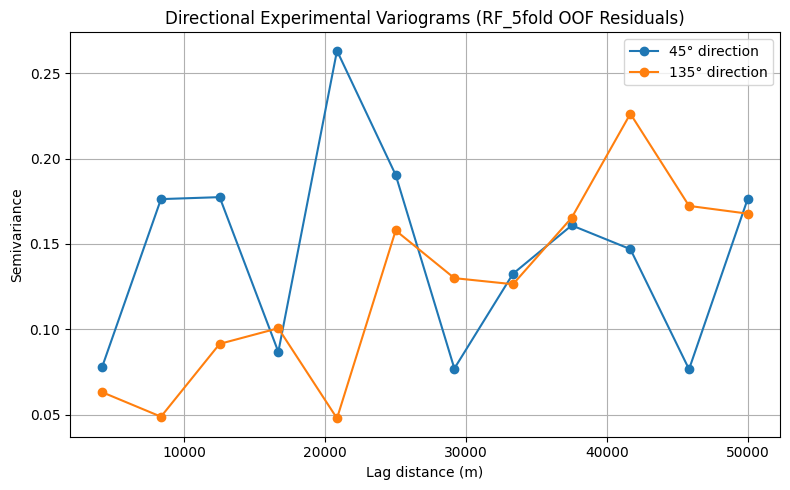

Saved spatially balanced sampled residuals → rf_oof_residuals_spatial_subset_skgstat.csv


In [20]:
# Spatially balanced sampling + directional variograms using skgstat for RF_5fold OOF residuals (~3000 points).
#!/usr/bin/env python3
"""
Spatially balanced sampling + directional variograms using skgstat
for RF_5fold OOF residuals (~3000 points).

Requirements:
    pip install numpy pandas scikit-learn scipy skgstat matplotlib
"""

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.qmc import Halton
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram

# ===============================
# USER CONFIG
# ===============================
CSV = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"
SITE_COORDS = "/Users/inesschwartz/Desktop/model/model_datasets/train_final1.csv"

MODEL_NAME = "RF_5fold"
RESIDUAL_COL = "error"
TARGET_N = 3000   # number of spatially balanced points

# Variogram parameters
n_lags = 12
maxlag = 50000       # adjust to your scale
tolerance = 22.5
normalize = True
directions = [0, 90]  # example directions ## TRY W 0 AND 90 JUST IN CASE

# ===============================
# LOAD AND MERGE DATA
# ===============================
pred = pd.read_csv(CSV)
coords = pd.read_csv(SITE_COORDS)[['site_info_id', 'X_coord', 'Y_coord']]

# Filter RF_5fold and merge coordinates
rf = pred[pred["model"] == MODEL_NAME].copy()
df = rf.merge(coords, on="site_info_id", how="left")
df = df.dropna(subset=['X_coord', 'Y_coord', RESIDUAL_COL])
df[RESIDUAL_COL] = df[RESIDUAL_COL].astype(float)
print(f"Loaded {len(df)} RF_5fold OOF points with coordinates.")

# ===============================
# SPATIALLY BALANCED SAMPLING (~3000 points)
# ===============================
scaler = MinMaxScaler()
xy_norm = scaler.fit_transform(df[['X_coord', 'Y_coord']].values)

halton = Halton(d=2, scramble=False)
target_grid = halton.random(n=TARGET_N)

tree = cKDTree(xy_norm)
_, indices = tree.query(target_grid)
sampled_df = df.iloc[indices].copy().drop_duplicates(subset=['site_info_id'])
print(f"Spatially balanced sample size: {len(sampled_df)}")

# ===============================
# PREPARE DATA FOR SKGSTAT
# ===============================
coords_array = sampled_df[['X_coord', 'Y_coord']].values
# Center coordinates to avoid float issues
coords_array = coords_array - coords_array.mean(axis=0)

residuals = sampled_df[RESIDUAL_COL].values

# ===============================
# COMPUTE DIRECTIONAL VARIOGRAMS
# ===============================
plt.figure(figsize=(8,5))

vg_dict = {}
for az in directions:
    vdir = DirectionalVariogram(
        coordinates=coords_array,
        values=residuals,
        azimuth=az,
        n_lags=n_lags,
        maxlag=maxlag,
        tolerance=tolerance,
        normalize=normalize
    )
    vg_dict[az] = vdir
    plt.plot(vdir.bins, vdir.experimental, 'o-', label=f'{az}° direction')

plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms (RF_5fold OOF Residuals)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# SAVE SAMPLED DATA
# ===============================
sampled_df.to_csv("rf_oof_residuals_spatial_subset_skgstat.csv", index=False)
print("Saved spatially balanced sampled residuals → rf_oof_residuals_spatial_subset_skgstat.csv")


**Note: not seeing patterns in the semivariogram above**

### Building Variogram and Make RF+OK tif (with inferred fit)

The script below cross validates (again) the Random Forest model, but this time builds a variogram from the residuals and runs an OK prediction model on them. 
The variogram is inferred using from sklearn.model_selection (KFold) and pykrige.ok (OrdinaryKriging). The function "estimate_anisotropy" helps to infer the best parameters for running an ordinary kriging model on the residuals. 
Ultimately, the results only improve a tiny bit from RF alone proving that there is very little spatial correlation in SOC



In [15]:
## cross validation w inferred variogram parametres PER SUBSET AND PER FOLD from residuals (IPSnD) 

#!/usr/bin/env python3
"""
RF + OK(residual) cross-validation across declustered subsets.
Per-subset, per-fold variogram inference from RF residuals.
Outputs:
 - summary CSV of metrics per subset & model
 - per-point predictions CSV
 - per-subset JSON variogram reports
"""

import os
import glob
import warnings
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from pykrige.ok import OrdinaryKriging

warnings.filterwarnings("ignore")

# -----------------------------
# PATHS & SETTINGS
# -----------------------------
DECLUSTER_DIR = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned"
OUTPUT_DIR = "/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# RF hyperparameters
RF_PARAMS = {
    "n_estimators": 500,
    "min_samples_leaf": 5,
    "max_features": 0.5,
    "max_depth": 20,
    "random_state": 42,
    "n_jobs": 4,
}

# default fallback variogram (used only if inference fails)
VARIOGRAM_MODEL = "spherical"
FALLBACK_VARIOGRAM = {
    "nugget": 0.087,
    "sill": 0.1983,
    "range": 32049,
    "anisotropy_scaling": 0.91,
    "anisotropy_angle": 135,
}

N_FOLDS = 5
MAX_DECLUSTERS = 50
N_VARIOGRAM_BINS = 12
DIRECTIONS = [0, 45, 90, 135]
ANGLE_TOL = 22.5

# -----------------------------
# METRICS helper
# -----------------------------
def compute_metrics(y_true, y_pred):
    return {
        "R2": float(r2_score(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
    }

# -----------------------------
# Variogram inference utilities
# (pairwise vectors, binning, directional semivariogram,
#  infer params, estimate_anisotropy)
# -----------------------------
def pairwise_vectors(coords, values):
    n = len(values)
    # all unique index pairs i<j
    idx = np.array([(i, j) for i in range(n) for j in range(i + 1, n)])
    pi = coords[idx[:, 0]]
    pj = coords[idx[:, 1]]

    dx = pj[:, 0] - pi[:, 0]
    dy = pj[:, 1] - pi[:, 1]
    h = np.sqrt(dx ** 2 + dy ** 2)
    g = 0.5 * (values[idx[:, 1]] - values[idx[:, 0]]) ** 2
    return h, g, dx, dy

def empirical_semivariogram_binned(h, g, n_bins=12):
    if len(h) < n_bins:
        return None
    bins = np.linspace(h.min(), h.max(), n_bins + 1)
    bin_idx = np.digitize(h, bins) - 1
    bin_centers = []
    gamma_vals = []
    for k in range(n_bins):
        mask = bin_idx == k
        if np.sum(mask) >= 5:
            bin_centers.append(np.mean(h[mask]))
            gamma_vals.append(np.mean(g[mask]))
    if len(bin_centers) < 3:
        return None
    return np.array(bin_centers), np.array(gamma_vals)

def empirical_directional_semivariogram(coords, values, angles, angle_tol, n_bins=12, min_pairs=20):
    h, g, dx, dy = pairwise_vectors(coords, values)
    results = {}
    norms = np.sqrt(dx ** 2 + dy ** 2)
    valid = norms > 0
    for angle in angles:
        theta = np.deg2rad(angle)
        direction_vector = np.array([np.cos(theta), np.sin(theta)])
        cosang = (dx[valid] * direction_vector[0] + dy[valid] * direction_vector[1]) / norms[valid]
        cosang = np.clip(cosang, -1.0, 1.0)
        ang = np.rad2deg(np.arccos(cosang))
        mask = ang <= angle_tol
        if np.sum(mask) < min_pairs:
            results[angle] = None
            continue
        h_dir = h[valid][mask]
        g_dir = g[valid][mask]
        binned = empirical_semivariogram_binned(h_dir, g_dir, n_bins=n_bins)
        results[angle] = binned
    return results

def infer_variogram_params_from_bins(bin_h, bin_g):
    if bin_h is None or bin_g is None:
        return None
    sill = float(np.percentile(bin_g, 95))
    target = 0.95 * sill
    try:
        range_mask = np.where(bin_g >= target)[0]
        if len(range_mask) > 0:
            a = float(bin_h[range_mask[0]])
        else:
            a = float(bin_h.max())
    except Exception:
        a = float(bin_h.max())
    nugget = float(bin_g.min())
    return {"sill": sill, "range": a, "nugget": nugget}

def estimate_anisotropy(coords, values, n_bins=12, angles=DIRECTIONS, angle_tol=ANGLE_TOL, min_pairs=20):
    """
    Infer directional variograms and return a dict of params compatible with PyKrige:
      {"nugget", "sill", "range", "anisotropy_angle", "anisotropy_scaling"}
    Returns None if no usable fit.
    """
    if len(values) < 30:
        # too few points to infer reliably
        return None

    directional = empirical_directional_semivariogram(coords, values, angles, angle_tol, n_bins=n_bins, min_pairs=min_pairs)
    fitted = {}
    for angle in angles:
        d = directional.get(angle)
        if d is None:
            fitted[angle] = None
            continue
        bin_h, bin_g = d
        params = infer_variogram_params_from_bins(bin_h, bin_g)
        fitted[angle] = params

    good = {ang: p for ang, p in fitted.items() if p is not None}
    if len(good) == 0:
        return None

    # choose direction with max range as principal direction
    best_dir = max(good.keys(), key=lambda a: good[a]["range"])
    best_params = good[best_dir]

    # anisotropy scaling = min_range / max_range (ratio <= 1)
    ranges = [p["range"] for p in good.values()]
    anis_scaling = float(min(ranges) / max(ranges)) if max(ranges) > 0 else 1.0

    return {
        "nugget": float(best_params["nugget"]),
        "sill": float(best_params["sill"]),
        "range": float(best_params["range"]),
        "anisotropy_angle": float(best_dir),
        "anisotropy_scaling": float(anis_scaling),
    }

# -----------------------------
# RF CV + OK(residuals) per-fold
# -----------------------------
def rf_ok_residuals_cv(X, y, coords, k=N_FOLDS, n_variogram_bins=N_VARIOGRAM_BINS, subset_index=None):
    """
    Returns:
      rf_metrics, ok_resid_metrics, hybrid_metrics,
      y_pred_rf_all, y_pred_ok_resid_all, y_pred_hybrid_all, variogram_report
    where each prediction array is length N (in original order).
    """
    n = len(y)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    y_pred_rf = np.zeros(n, dtype=float)
    y_pred_ok_resid = np.zeros(n, dtype=float)
    y_pred_hybrid = np.zeros(n, dtype=float)
    variogram_report = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
        X_tr = X.iloc[train_idx]
        X_te = X.iloc[test_idx]
        y_tr = y[train_idx]
        y_te = y[test_idx]
        coords_tr = coords[train_idx]
        coords_te = coords[test_idx]

        # fit RF
        rf = RandomForestRegressor(**RF_PARAMS)
        rf.fit(X_tr, y_tr)

        # RF predictions
        y_pred_rf_train = rf.predict(X_tr)
        y_pred_rf[test_idx] = rf.predict(X_te)

        # residuals on training
        resid_tr = y_tr - y_pred_rf_train

        # infer variogram from training residuals
        inferred = estimate_anisotropy(coords_tr, resid_tr, n_bins=n_variogram_bins)

        if inferred is None:
            # fallback: use mean residual
            mean_resid = float(np.mean(resid_tr))
            kriged_vals = np.full(len(test_idx), mean_resid)
            report = {"subset": subset_index, "fold": fold_idx, "variogram": "fallback_mean", "params": None}
        else:
            variogram_params = {
                "sill": inferred["sill"],
                "nugget": inferred["nugget"],
                "range": inferred["range"],
                "anisotropy_scaling": inferred.get("anisotropy_scaling", 1.0),
                "anisotropy_angle": inferred.get("anisotropy_angle", 0.0)
            }
            try:
                ok = OrdinaryKriging(
                    coords_tr[:, 0], coords_tr[:, 1], resid_tr,
                    variogram_model=VARIOGRAM_MODEL,
                    variogram_parameters=variogram_params,
                    enable_plotting=False,
                    verbose=False
                )
                z_resid, _ = ok.execute("points", coords_te[:, 0], coords_te[:, 1])
                kriged_vals = np.array(z_resid).ravel().astype(float)
                report = {"subset": subset_index, "fold": fold_idx, "variogram": "inferred", "params": variogram_params}
            except Exception as e:
                mean_resid = float(np.mean(resid_tr))
                kriged_vals = np.full(len(test_idx), mean_resid)
                report = {"subset": subset_index, "fold": fold_idx, "variogram": "fallback_mean", "params": None, "error": str(e)}

        y_pred_ok_resid[test_idx] = kriged_vals
        y_pred_hybrid[test_idx] = y_pred_rf[test_idx] + y_pred_ok_resid[test_idx]
        variogram_report.append(report)

    rf_metrics = compute_metrics(y, y_pred_rf)
    ok_resid_metrics = compute_metrics(y, y_pred_ok_resid)
    hybrid_metrics = compute_metrics(y, y_pred_hybrid)

    return rf_metrics, ok_resid_metrics, hybrid_metrics, y_pred_rf, y_pred_ok_resid, y_pred_hybrid, variogram_report

# -----------------------------
# MAIN LOOP across declustered subsets
# -----------------------------
def main():
    files = sorted(glob.glob(os.path.join(DECLUSTER_DIR, "decluster_run_*.csv")))[:MAX_DECLUSTERS]
    summary_records = []
    point_records = []
    rf_template_metrics = []

    for i, path in enumerate(tqdm(files, desc="Decluster subsets")):
        subset_index = i + 1
        df = pd.read_csv(path)
        n = len(df)
        if n < 10:
            print(f"Skipping subset {subset_index} (only {n} points)")
            continue

        # Ensure site ids safe string representation
        site_ids = df["site_info_id"].astype(str).values if "site_info_id" in df.columns else np.arange(n)

        y = df["log_soc_stock"].values
        coords = df[["X_coord", "Y_coord"]].values
        X = df.drop(columns=["log_soc_stock", "X_coord", "Y_coord", "site_info_id"], errors="ignore")
        if X.shape[1] == 0:
            X = pd.DataFrame({"const": np.ones(n)})

        # Run RF CV + OK(residuals)
        rf_metrics, ok_resid_metrics, hybrid_metrics, y_rf_cv, y_ok_resid_cv, y_hybrid_cv, variogram_report = rf_ok_residuals_cv(
            X, y, coords, k=N_FOLDS, n_variogram_bins=N_VARIOGRAM_BINS, subset_index=subset_index
        )

        # Save per-subset summary
        summary_records.append({"subset": subset_index, "model": "RF_5fold", **rf_metrics})
        summary_records.append({"subset": subset_index, "model": "OK_resid_5fold", **ok_resid_metrics})
        summary_records.append({"subset": subset_index, "model": "RF+OK_5fold", **hybrid_metrics})

        # Save per-point predictions for selected models (RF, hybrid)
        for model_name, preds in {"RF_5fold": y_rf_cv, "RF+OK_5fold": y_hybrid_cv}.items():
            df_tmp = pd.DataFrame({
                "subset": subset_index,
                "model": model_name,
                "site_info_id": site_ids,
                "y_true": y,
                "y_pred": preds,
                "error": y - preds,
                "abs_error": np.abs(y - preds)
            })
            point_records.append(df_tmp)

        # Write variogram report JSON for this subset
        with open(os.path.join(OUTPUT_DIR, f"variogram_report_subset{subset_index}.json"), "w") as f:
            json.dump(variogram_report, f, indent=2)

    # Save summary and points
    if len(summary_records) == 0:
        print("No subsets processed. Exiting.")
        return

    summary_df = pd.DataFrame(summary_records)
    points_df = pd.concat(point_records, ignore_index=True)

    summary_csv = os.path.join(OUTPUT_DIR, "RFOK_res_cv_summary_metrics_all_declusters.csv")
    points_csv = os.path.join(OUTPUT_DIR, "RFOK_res_cv_point_predictions_all_declusters.csv")
    summary_df.to_csv(summary_csv, index=False)
    points_df.to_csv(points_csv, index=False)

    print("\n✅ CV complete.")
    print(f"Summary metrics → {summary_csv}")
    print(f"Point predictions → {points_csv}")
    print(f"Variogram reports saved as JSON per subset in → {OUTPUT_DIR}")

if __name__ == "__main__":
    main()


Decluster subsets: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it]



✅ CV complete.
Summary metrics → /Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/RFOK_res_cv_summary_metrics_all_declusters.csv
Point predictions → /Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/RFOK_res_cv_point_predictions_all_declusters.csv
Variogram reports saved as JSON per subset in → /Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res


In [1]:
## BAGGED MAP OF RFOK FROM INDIVIDUAL VARIOGRAM (ABOVE)

# Bagged RF+OK maps from multiple decluster subsets
# Produces mean & std GeoTIFFs for RF+OK (log_soc_stock) and back-transformed (Mg C/ha)
import os
import glob
import warnings
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from pykrige.ok import OrdinaryKriging

warnings.filterwarnings("ignore")

# -----------------------------
# PATHS & SETTINGS (EDIT IF NEEDED)
# -----------------------------
DECLUSTER_DIR = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned"
GRID_CSV = "/Users/inesschwartz/Desktop/model/covariates_stack_1km_utm33s_aligned.csv"
OUTPUT_DIR = "/Users/inesschwartz/Desktop/model/bagged_maps"
os.makedirs(OUTPUT_DIR, exist_ok=True)

GRID_X_COL = "X_coord"   # change if your grid uses different names
GRID_Y_COL = "Y_coord"

CRS_EPSG = "EPSG:32733"
PIXEL_SIZE = 1000.0       # 1 km resolution

MAX_DECLUSTERS = 50  # how many decluster CSV files to use (set None to use all)

# RF hyperparameters
RF_PARAMS = {
    "n_estimators": 500,
    "min_samples_leaf": 5,
    "max_features": 0.5,
    "max_depth": 20,
    "random_state": 42,
    "n_jobs": -1,
}

# Variogram/kriging settings and fallback
VARIOGRAM_MODEL = "spherical"
FALLBACK_MEAN_RESID = True  # if kriging fails, use mean residual as fallback

# Back-transform settings
WRITE_BACKTRANSFORMED = True  # write Mg C/ha outputs (exp of log predictions)
# -----------------------------
# Load grid and build raster layout
# -----------------------------
grid = pd.read_csv(GRID_CSV)
if GRID_X_COL not in grid.columns or GRID_Y_COL not in grid.columns:
    raise ValueError(f"Grid CSV must contain {GRID_X_COL} and {GRID_Y_COL}")

xs = np.sort(grid[GRID_X_COL].unique())
ys = np.sort(grid[GRID_Y_COL].unique())  # ascending (south→north)

nx = len(xs)
ny = len(ys)

print(f"Grid: nx={nx}, ny={ny}, total points={len(grid)}")

# origin for GeoTIFF (top-left): xmin, ymax
xmin = xs.min()
ymax = ys.max()
transform = from_origin(xmin, ymax, PIXEL_SIZE, PIXEL_SIZE)

# Prepare feature matrix for grid predictions (drop coords)
X_grid = grid.drop(columns=[GRID_X_COL, GRID_Y_COL], errors="ignore")

# -----------------------------
# Helper: turn flat predictions into 2D array (ny, nx)
# -----------------------------
def predictions_to_grid(pred_flat, x_vals, y_vals):
    dfp = pd.DataFrame({
        GRID_X_COL: grid[GRID_X_COL].values,
        GRID_Y_COL: grid[GRID_Y_COL].values,
        "pred": pred_flat,
    })
    pivot = dfp.pivot(index=GRID_Y_COL, columns=GRID_X_COL, values="pred")
    # Ensure proper ordering
    pivot = pivot.reindex(index=np.sort(y_vals), columns=np.sort(x_vals))
    arr = pivot.values  # rows = y (ascending), cols = x (ascending)
    # For GeoTIFF, rows go from top (max y) to bottom (min y)
    arr = np.flipud(arr)
    return arr

# -----------------------------
# Storage for per-decluster predictions (flat order = grid rows)
# -----------------------------
rf_preds_all = []    # RF-only predictions on grid, log-space
ok_preds_all = []    # kriged residuals on grid, log-space
rfok_preds_all = []  # RF+OK hybrid predictions on grid, log-space

# -----------------------------
# Find decluster files
# -----------------------------
files = sorted(glob.glob(os.path.join(DECLUSTER_DIR, "decluster_run_*.csv")))
if len(files) == 0:
    raise FileNotFoundError(f"No decluster CSV files found in {DECLUSTER_DIR}")

if MAX_DECLUSTERS is not None:
    files = files[:MAX_DECLUSTERS]

print(f"Found {len(files)} decluster files. Processing...")

# -----------------------------
# Variogram helper: estimate from residuals (simple approach)
# -----------------------------
def estimate_variogram_params(coords, resid):
    # Minimal wrapper: if too few points -> return None
    if len(resid) < 20:
        return None
    # crude empirical sill/nugget/range estimate:
    # fall back to provided defaults if anything fails
    try:
        # pairwise distances and semivariances
        dx = coords[:, 0][:, None] - coords[:, 0][None, :]
        dy = coords[:, 1][:, None] - coords[:, 1][None, :]
        h = np.sqrt(dx**2 + dy**2)
        diff = resid[:, None] - resid[None, :]
        g = 0.5 * (diff**2)
        # take upper triangle
        triu = np.triu_indices_from(h, k=1)
        distances = h[triu]
        gammas = g[triu]
        # bin by distance
        bins = np.linspace(0, np.percentile(distances, 90), 12 + 1)
        bin_idx = np.digitize(distances, bins) - 1
        bin_centers = []
        gamma_means = []
        for b in range(len(bins)-1):
            mask = bin_idx == b
            if np.sum(mask) >= 5:
                bin_centers.append(np.mean(distances[mask]))
                gamma_means.append(np.mean(gammas[mask]))
        if len(gamma_means) < 3:
            return None
        sill = float(np.percentile(gamma_means, 95))
        nugget = float(np.min(gamma_means))
        # find range where gamma ~ 95% sill
        try:
            idx = next(i for i, gv in enumerate(gamma_means) if gv >= 0.95 * sill)
            range_est = float(bin_centers[idx])
        except StopIteration:
            range_est = float(bin_centers[-1])
        return {"sill": sill, "nugget": nugget, "range": range_est}
    except Exception:
        return None

# -----------------------------
# MAIN loop: train RF on each decluster, krige residuals to grid, store predictions
# -----------------------------
for i, path in enumerate(tqdm(files, desc="Declusters (mapping)"), start=1):
    df = pd.read_csv(path)
    if "log_soc_stock" not in df.columns:
        raise ValueError(f"{path} missing 'log_soc_stock' column")
    # training vectors
    y = df["log_soc_stock"].values.astype(float)
    coords = df[[GRID_X_COL, GRID_Y_COL]].values
    X_train = df.drop(columns=["log_soc_stock", GRID_X_COL, GRID_Y_COL, "site_info_id"], errors="ignore")

    print(f"\n📂 Subset {i:03d} | n = {len(df)}")

    # 1) fit RF on full subset
    try:
        rf = RandomForestRegressor(**RF_PARAMS)
        rf.fit(X_train, y)
    except Exception as e:
        print(f"  ❌ RF failed for subset {i}: {e}")
        continue

    # RF predict to grid (log-space)
    try:
        rf_grid_pred = rf.predict(X_grid)
    except Exception as e:
        print(f"  ❌ RF predict->grid failed for subset {i}: {e}")
        continue

    # residuals on training
    y_pred_train = rf.predict(X_train)
    resid_train = y - y_pred_train

    # 2) infer variogram params and krige residuals to grid
    variogram_params = estimate_variogram_params(coords, resid_train)
    if variogram_params is None:
        # fallback: use mean residual everywhere
        mean_resid = float(np.mean(resid_train))
        ok_grid_pred = np.full(len(grid), mean_resid, dtype=float)
        print(f"  ⚠️ Variogram inference failed — using mean residual fallback for subset {i}")
    else:
        # build pykrige OrdinaryKriging using training coords & residuals
        try:
            ok = OrdinaryKriging(
                coords[:, 0], coords[:, 1], resid_train,
                variogram_model=VARIOGRAM_MODEL,
                variogram_parameters={
                    "sill": variogram_params["sill"],
                    "nugget": variogram_params["nugget"],
                    "range": variogram_params["range"],
                },
                enable_plotting=False,
                verbose=False,
            )
            # predict to the grid points (points mode)
            # Note: pykrige expects 1D arrays for x and y
            z_resid_grid, ss = ok.execute("points", grid[GRID_X_COL].values, grid[GRID_Y_COL].values)
            ok_grid_pred = np.array(z_resid_grid).ravel().astype(float)
        except Exception as e:
            # fallback to mean residual
            mean_resid = float(np.mean(resid_train))
            ok_grid_pred = np.full(len(grid), mean_resid, dtype=float)
            print(f"  ⚠️ Kriging failed for subset {i}, using mean residual fallback. Error: {e}")

    # hybrid prediction on grid (log-space)
    rfok_grid_pred = rf_grid_pred + ok_grid_pred

    # store
    rf_preds_all.append(rf_grid_pred)
    ok_preds_all.append(ok_grid_pred)
    rfok_preds_all.append(rfok_grid_pred)

# Ensure we have at least one successful run
if len(rfok_preds_all) == 0:
    raise RuntimeError("No successful decluster runs produced predictions. Check logs above.")

# Convert to arrays: shape (D, P) where P = number of grid points
rf_preds_all = np.vstack(rf_preds_all)      # (D, P)
ok_preds_all = np.vstack(ok_preds_all)      # (D, P)
rfok_preds_all = np.vstack(rfok_preds_all)  # (D, P)

# Mean & std over declusters (axis=0 -> per-grid-point)
rf_mean = rf_preds_all.mean(axis=0)
rf_std  = rf_preds_all.std(axis=0)

ok_mean = ok_preds_all.mean(axis=0)
ok_std  = ok_preds_all.std(axis=0)

rfok_mean = rfok_preds_all.mean(axis=0)
rfok_std  = rfok_preds_all.std(axis=0)

# Also compute means/stds in original units by exponentiating each ensemble member then aggregating
if WRITE_BACKTRANSFORMED:
    rfok_exp_all = np.exp(rfok_preds_all)  # (D,P) in Mg C/ha (original)
    rfok_exp_mean = rfok_exp_all.mean(axis=0)
    rfok_exp_std  = rfok_exp_all.std(axis=0)
else:
    rfok_exp_mean = None
    rfok_exp_std = None

# Turn flat -> 2D arrays (ny, nx)
rfok_mean_grid = predictions_to_grid(rfok_mean, xs, ys)
rfok_std_grid  = predictions_to_grid(rfok_std, xs, ys)

if WRITE_BACKTRANSFORMED:
    rfok_exp_mean_grid = predictions_to_grid(rfok_exp_mean, xs, ys)
    rfok_exp_std_grid  = predictions_to_grid(rfok_exp_std, xs, ys)

# -----------------------------
# Save GeoTIFFs
# -----------------------------
def write_tif(path, arr2d, transform, crs):
    ny, nx = arr2d.shape
    with rasterio.open(
        path,
        "w",
        driver="GTiff",
        height=ny,
        width=nx,
        count=1,
        dtype="float32",
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(arr2d.astype("float32"), 1)

# write log-space hybrid mean/std
write_tif(os.path.join(OUTPUT_DIR, "v3_RFOK_logSOC_mean.tif"), rfok_mean_grid, transform, CRS_EPSG)
write_tif(os.path.join(OUTPUT_DIR, "v3_RFOK_logSOC_std.tif"),  rfok_std_grid,  transform, CRS_EPSG)

# write back-transformed ensemble mean/std (Mg C/ha)
if WRITE_BACKTRANSFORMED:
    write_tif(os.path.join(OUTPUT_DIR, "v3_RFOK_SOC_MgC_ha_mean.tif"), rfok_exp_mean_grid, transform, CRS_EPSG)
    write_tif(os.path.join(OUTPUT_DIR, "v3_RFOK_SOC_MgC_ha_std.tif"),  rfok_exp_std_grid,  transform, CRS_EPSG)

print("\n✅ Bagged maps written to:")
print(OUTPUT_DIR)

Grid: nx=1352, ny=1521, total points=1259342
Found 50 decluster files. Processing...


Declusters (mapping):   0%|          | 0/50 [00:00<?, ?it/s]


📂 Subset 001 | n = 634


Declusters (mapping):   2%|▏         | 1/50 [02:48<2:18:00, 168.99s/it]


📂 Subset 002 | n = 634


Declusters (mapping):   4%|▍         | 2/50 [05:01<1:57:56, 147.44s/it]


📂 Subset 003 | n = 634


Declusters (mapping):   6%|▌         | 3/50 [07:18<1:51:43, 142.63s/it]


📂 Subset 004 | n = 634


Declusters (mapping):   8%|▊         | 4/50 [09:32<1:46:48, 139.32s/it]


📂 Subset 005 | n = 634


Declusters (mapping):  10%|█         | 5/50 [11:51<1:44:26, 139.26s/it]


📂 Subset 006 | n = 634


Declusters (mapping):  12%|█▏        | 6/50 [13:57<1:38:40, 134.55s/it]


📂 Subset 007 | n = 634


Declusters (mapping):  14%|█▍        | 7/50 [19:32<2:23:33, 200.31s/it]


📂 Subset 008 | n = 634


Declusters (mapping):  16%|█▌        | 8/50 [25:04<2:49:34, 242.26s/it]


📂 Subset 009 | n = 634


Declusters (mapping):  18%|█▊        | 9/50 [27:22<2:23:16, 209.67s/it]


📂 Subset 010 | n = 634


Declusters (mapping):  20%|██        | 10/50 [29:34<2:03:49, 185.74s/it]


📂 Subset 011 | n = 634


Declusters (mapping):  22%|██▏       | 11/50 [31:50<1:50:48, 170.47s/it]


📂 Subset 012 | n = 634


Declusters (mapping):  24%|██▍       | 12/50 [34:05<1:41:03, 159.56s/it]


📂 Subset 013 | n = 634


Declusters (mapping):  26%|██▌       | 13/50 [36:34<1:36:28, 156.43s/it]


📂 Subset 014 | n = 634


Declusters (mapping):  28%|██▊       | 14/50 [38:44<1:28:59, 148.31s/it]


📂 Subset 015 | n = 634


Declusters (mapping):  30%|███       | 15/50 [41:19<1:27:48, 150.54s/it]


📂 Subset 016 | n = 634


Declusters (mapping):  32%|███▏      | 16/50 [47:01<1:57:48, 207.89s/it]


📂 Subset 017 | n = 634


Declusters (mapping):  34%|███▍      | 17/50 [49:28<1:44:23, 189.80s/it]


📂 Subset 018 | n = 634


Declusters (mapping):  36%|███▌      | 18/50 [51:58<1:34:53, 177.91s/it]


📂 Subset 019 | n = 634


Declusters (mapping):  38%|███▊      | 19/50 [58:03<2:00:51, 233.92s/it]


📂 Subset 020 | n = 634


Declusters (mapping):  40%|████      | 20/50 [1:03:07<2:07:28, 254.95s/it]


📂 Subset 021 | n = 634


Declusters (mapping):  42%|████▏     | 21/50 [1:05:10<1:44:09, 215.49s/it]


📂 Subset 022 | n = 634


Declusters (mapping):  44%|████▍     | 22/50 [1:10:29<1:54:58, 246.37s/it]


📂 Subset 023 | n = 634


Declusters (mapping):  46%|████▌     | 23/50 [1:12:29<1:33:49, 208.48s/it]


📂 Subset 024 | n = 634


Declusters (mapping):  48%|████▊     | 24/50 [1:14:23<1:18:08, 180.31s/it]


📂 Subset 025 | n = 634


Declusters (mapping):  50%|█████     | 25/50 [1:16:26<1:07:51, 162.86s/it]


📂 Subset 026 | n = 634


Declusters (mapping):  52%|█████▏    | 26/50 [1:21:31<1:22:15, 205.65s/it]


📂 Subset 027 | n = 634


Declusters (mapping):  54%|█████▍    | 27/50 [1:23:43<1:10:22, 183.57s/it]


📂 Subset 028 | n = 634


Declusters (mapping):  56%|█████▌    | 28/50 [1:25:56<1:01:47, 168.50s/it]


📂 Subset 029 | n = 634


Declusters (mapping):  58%|█████▊    | 29/50 [1:28:05<54:46, 156.51s/it]  


📂 Subset 030 | n = 634


Declusters (mapping):  60%|██████    | 30/50 [1:30:11<49:08, 147.44s/it]


📂 Subset 031 | n = 634


Declusters (mapping):  62%|██████▏   | 31/50 [1:32:07<43:41, 137.95s/it]


📂 Subset 032 | n = 634


Declusters (mapping):  64%|██████▍   | 32/50 [1:37:04<55:41, 185.65s/it]


📂 Subset 033 | n = 634


Declusters (mapping):  66%|██████▌   | 33/50 [1:39:50<50:58, 179.89s/it]


📂 Subset 034 | n = 634


Declusters (mapping):  68%|██████▊   | 34/50 [1:45:43<1:01:44, 231.54s/it]


📂 Subset 035 | n = 634


Declusters (mapping):  70%|███████   | 35/50 [1:47:51<50:09, 200.61s/it]  


📂 Subset 036 | n = 634


Declusters (mapping):  72%|███████▏  | 36/50 [1:53:36<56:53, 243.83s/it]


📂 Subset 037 | n = 634


Declusters (mapping):  74%|███████▍  | 37/50 [1:59:00<58:02, 267.87s/it]


📂 Subset 038 | n = 634


Declusters (mapping):  76%|███████▌  | 38/50 [2:01:11<45:23, 226.99s/it]


📂 Subset 039 | n = 634


Declusters (mapping):  78%|███████▊  | 39/50 [2:03:24<36:25, 198.69s/it]


📂 Subset 040 | n = 634


Declusters (mapping):  80%|████████  | 40/50 [2:05:37<29:49, 178.91s/it]


📂 Subset 041 | n = 634


Declusters (mapping):  82%|████████▏ | 41/50 [2:07:59<25:10, 167.85s/it]


📂 Subset 042 | n = 634


Declusters (mapping):  84%|████████▍ | 42/50 [2:10:26<21:33, 161.66s/it]


📂 Subset 043 | n = 634


Declusters (mapping):  86%|████████▌ | 43/50 [2:12:49<18:12, 156.08s/it]


📂 Subset 044 | n = 634


Declusters (mapping):  88%|████████▊ | 44/50 [2:15:08<15:06, 151.02s/it]


📂 Subset 045 | n = 634


Declusters (mapping):  90%|█████████ | 45/50 [2:17:44<12:42, 152.57s/it]


📂 Subset 046 | n = 634


Declusters (mapping):  92%|█████████▏| 46/50 [2:20:20<10:13, 153.37s/it]


📂 Subset 047 | n = 634


Declusters (mapping):  94%|█████████▍| 47/50 [2:22:53<07:40, 153.50s/it]


📂 Subset 048 | n = 634


Declusters (mapping):  96%|█████████▌| 48/50 [2:25:19<05:02, 151.28s/it]


📂 Subset 049 | n = 634


Declusters (mapping):  98%|█████████▊| 49/50 [2:27:50<02:31, 151.14s/it]


📂 Subset 050 | n = 634


Declusters (mapping): 100%|██████████| 50/50 [2:30:11<00:00, 180.24s/it]



✅ Bagged maps written to:
/Users/inesschwartz/Desktop/model/bagged_maps


## trying using SAME estimated parameters FOR EACH SUBSET RESIDUAL 

In [24]:
# ## try using median residuals variogram (results not as good as the individual subset)

# import os
# import glob
# import warnings
# import json
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.model_selection import KFold
# from pykrige.ok import OrdinaryKriging
# import matplotlib.pyplot as plt

# warnings.filterwarnings("ignore")

# # -----------------------------
# # PATHS & SETTINGS
# # -----------------------------
# DECLUSTER_DIR = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned"
# OUTPUT_DIR = "/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # RF hyperparameters
# RF_PARAMS = {
#     "n_estimators": 500,
#     "min_samples_leaf": 5,
#     "max_features": 0.5,
#     "max_depth": 20,
#     "random_state": 42,
#     "n_jobs": 4,
# }

# # Default variogram
# VARIOGRAM_MODEL = "spherical"
# VARIOGRAM = {
#     "nugget": 0.08,
#     "sill": 0.21,
#     "range": 50000,
#     "anisotropy_scaling": 0.40,
#     "anisotropy_angle": 135,
# }

# N_FOLDS = 5
# MAX_DECLUSTERS = 50
# DIRECTIONS = [0, 45, 90, 135]
# ANGLE_TOL = 22.5
# MIN_POINTS_FOR_DIRECTION = 20

# # -----------------------------
# # HELPER FUNCTIONS
# # -----------------------------
# def compute_metrics(y_true, y_pred):
#     return {
#         "R2": r2_score(y_true, y_pred),
#         "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
#         "MAE": mean_absolute_error(y_true, y_pred),
#     }

# # (pairwise_vectors, empirical_semivariogram_binned, empirical_directional_semivariogram,
# # infer_variogram_params_from_bins, estimate_anisotropy functions unchanged...)

# # -----------------------------
# # RF 5-fold CV
# # -----------------------------
# def rf_cv_5fold(X, y, k=N_FOLDS):
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)
#     y_pred = np.zeros(len(y), dtype=float)
#     for train_idx, test_idx in kf.split(X):
#         X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
#         y_tr = y[train_idx]
#         rf = RandomForestRegressor(**RF_PARAMS)
#         rf.fit(X_tr, y_tr)
#         y_pred[test_idx] = rf.predict(X_te)
#     return compute_metrics(y, y_pred), y_pred

# # -----------------------------
# # OK LOO CV
# # -----------------------------
# def ok_loo_cv(coords, y, variogram, model=VARIOGRAM_MODEL):
#     n = len(y); y_pred = np.zeros(n, dtype=float)
#     for i in tqdm(range(n), desc="LOO OK", leave=False):
#         mask = np.ones(n, dtype=bool); mask[i]=False
#         ok = OrdinaryKriging(coords[mask,0], coords[mask,1], y[mask],
#                              variogram_model=model,
#                              variogram_parameters=variogram,
#                              enable_plotting=False, verbose=False)
#         z,_=ok.execute("points", np.array([coords[i,0]]), np.array([coords[i,1]]))
#         y_pred[i]=float(z.data[0])
#     return compute_metrics(y,y_pred), y_pred

# # -----------------------------
# # RF+OK 5-fold CV with variogram
# # -----------------------------
# def rf_ok_cv_5fold(X, y, coords, k=5, model="spherical", n_variogram_bins=12, subset_index=None, plot_dir=None):
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)
#     y_pred_rf = np.zeros(len(y), dtype=float)
#     y_pred_resid_ok = np.zeros(len(y), dtype=float)
#     y_pred_hybrid = np.zeros(len(y), dtype=float)
#     variogram_report = []
#     if plot_dir is not None: os.makedirs(plot_dir, exist_ok=True)

#     for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
#         X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
#         y_tr, y_te = y[train_idx], y[test_idx]
#         coords_tr, coords_te = coords[train_idx], coords[test_idx]

#         rf = RandomForestRegressor(**RF_PARAMS)
#         rf.fit(X_tr, y_tr)
#         y_pred_rf_train = rf.predict(X_tr)
#         y_pred_rf[test_idx] = rf.predict(X_te)

#         resid_tr = y_tr - y_pred_rf_train
#         # ---- OPTION 1 FIXED VARIOGRAM PARAMETERS ----
#         OPTION1_VARIOGRAM = {
#             "sill": 0.1983,
#             "nugget": 0.0871,
#             "range": 32049,
#             "anisotropy_angle": 135,
#             "anisotropy_scaling": 0.91
#         }

#         try:
#             ok = OrdinaryKriging(
#                 coords_tr[:, 0], coords_tr[:, 1], resid_tr,
#                 variogram_model="spherical",
#                 variogram_parameters=OPTION1_VARIOGRAM,
#                 enable_plotting=False,
#                 verbose=False
#             )

#             z_resid, _ = ok.execute("points", coords_te[:, 0], coords_te[:, 1])
#             kriged_vals = np.array(z_resid).ravel().astype(float)

#             report = {
#                 "fold": fold_idx,
#                 "variogram": "option1_fixed",
#                 "params": OPTION1_VARIOGRAM
#             }

#         except Exception:
#             mean_resid = float(np.mean(resid_tr))
#             kriged_vals = np.full(len(test_idx), mean_resid)
#             report = {"fold": fold_idx, "variogram": "fallback_mean"}

#         y_pred_resid_ok[test_idx] = kriged_vals
#         y_pred_hybrid[test_idx] = y_pred_rf[test_idx] + y_pred_resid_ok[test_idx]
#         variogram_report.append(report)

#     # Save variogram report as JSON
#     if subset_index is not None:
#         with open(os.path.join(OUTPUT_DIR, f"variogram_report_subset{subset_index}.json"), "w") as f:
#             json.dump(variogram_report, f, indent=2)

#     return compute_metrics(y,y_pred_rf), compute_metrics(y,y_pred_resid_ok), compute_metrics(y,y_pred_hybrid), \
#            y_pred_rf, y_pred_resid_ok, y_pred_hybrid, variogram_report

# # -----------------------------
# # MAIN LOOP
# # -----------------------------
# files = sorted(glob.glob(os.path.join(DECLUSTER_DIR,"decluster_run_*.csv")))[:MAX_DECLUSTERS]
# summary_records=[]; point_records=[]

# for i, path in enumerate(tqdm(files, desc="Declusters"), start=1):
#     df = pd.read_csv(path); n=len(df)

#     y = df["log_soc_stock"].values
#     coords = df[["X_coord","Y_coord"]].values
#     site_ids = df["site_info_id"].values if "site_info_id" in df.columns else np.arange(n)
#     X = df.drop(columns=["log_soc_stock","X_coord","Y_coord","site_info_id"], errors="ignore")
#     if X.shape[1]==0: X=pd.DataFrame({"const":np.ones(n)})

#     # RF 5-fold
#     rf_metrics, y_rf_cv = rf_cv_5fold(X,y,k=N_FOLDS)
#     # OK LOO
#     ok_metrics, y_ok_loo = ok_loo_cv(coords,y,VARIOGRAM)
#     # RF+OK 5-fold
#     rfok_rf_metrics, rfok_resid_metrics, rfok_hybrid_metrics, y_rf_5fold, y_ok_resid_5fold, y_hybrid_5fold, variogram_report = rf_ok_cv_5fold(
#         X,y,coords,k=N_FOLDS,model=VARIOGRAM_MODEL,
#         n_variogram_bins=12,subset_index=i
#     )

#     # Save metrics
#     summary_records.append({"subset":i,"model":"RF_5fold",**rf_metrics})
#     summary_records.append({"subset":i,"model":"OK_LOO",**ok_metrics})
#     summary_records.append({"subset":i,"model":"RF+OK_RF",**rfok_rf_metrics})
#     summary_records.append({"subset":i,"model":"OK_resid_5fold",**rfok_resid_metrics})
#     summary_records.append({"subset":i,"model":"RF+OK_5fold",**rfok_hybrid_metrics})

#     # Per-point predictions
#     for model_name,preds in {"RF_5fold":y_rf_cv,"OK_LOO":y_ok_loo,"RF+OK_5fold":y_hybrid_5fold}.items():
#         df_tmp=pd.DataFrame({
#             "subset":i,
#             "model":model_name,
#             "site_info_id":site_ids,
#             "y_true":y,
#             "y_pred":preds,
#             "error":y-preds,
#             "abs_error":np.abs(y-preds)
#         })
#         point_records.append(df_tmp)

# # Save summary and points
# summary_df = pd.DataFrame(summary_records)
# points_df = pd.concat(point_records, ignore_index=True)
# summary_csv = os.path.join(OUTPUT_DIR, "V_RFOK_res_cv_summary_metrics_all_declusters.csv")
# points_csv = os.path.join(OUTPUT_DIR, "V_RFOK_res_cv_point_predictions_all_declusters.csv")
# summary_df.to_csv(summary_csv, index=False)
# points_df.to_csv(points_csv, index=False)

# print("\n✅ CV complete.")
# print(f"Summary metrics → {summary_csv}")
# print(f"Point predictions → {points_csv}")
# print(f"Variogram reports saved as JSON per subset in → {OUTPUT_DIR}")

Declusters: 100%|██████████| 50/50 [23:36<00:00, 28.34s/it]



✅ CV complete.
Summary metrics → /Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/V_RFOK_res_cv_summary_metrics_all_declusters.csv
Point predictions → /Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/V_RFOK_res_cv_point_predictions_all_declusters.csv
Variogram reports saved as JSON per subset in → /Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res


## checking which (individual resid variogram vs same median variogram) gives better results

In [19]:
## checking which (individual resid variogram vs same median variogram) gives better results

import pandas as pd

# Load summaries
s1 = pd.read_csv("/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/RFOK_res_cv_summary_metrics_all_declusters.csv")
s2 = pd.read_csv("/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/V_RFOK_res_cv_summary_metrics_all_declusters.csv")

# Add a column so we can tell them apart later
s1["version"] = "Script1_inferred"
s2["version"] = "Script2_fixed"

models_to_compare = ["RF+OK_5fold"]

c1 = s1[s1["model"].isin(models_to_compare)]
c2 = s2[s2["model"].isin(models_to_compare)]

df = pd.concat([c1, c2], ignore_index=True)

comparison = df.groupby("version")[["R2", "RMSE", "MAE"]].mean()
print(comparison)



                        R2      RMSE       MAE
version                                       
Script1_inferred  0.377526  0.407441  0.299088
Script2_fixed     0.344622  0.418056  0.306637


In [ ]:
## trying using inferred parameters

## RFOK_res ensemble builder (bags declusters from cv_point_predictions and creates geotifs of RFOK_res predictions)
# =========================================================
# Bagged RF+OK (RFOK_res) SOC prediction using subset-specific variograms
# =========================================================

import os
import glob
import json
import warnings
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from pykrige.ok import OrdinaryKriging

warnings.filterwarnings("ignore")

# -----------------------------
# PATHS & SETTINGS
# -----------------------------
DECLUSTER_DIR = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned"
GRID_CSV = "/Users/inesschwartz/Desktop/model/covariates_stack_1km_utm33s_aligned.csv"
VARIO_JSON_DIR = "/Users/inesschwartz/Desktop/model/results_cv_global"  # variogram JSONs
OUTPUT_DIR = "/Users/inesschwartz/Desktop/model/bagged_maps_RFOK"
os.makedirs(OUTPUT_DIR, exist_ok=True)

GRID_X_COL = "X_coord"
GRID_Y_COL = "Y_coord"
CRS_EPSG = "EPSG:32733"
PIXEL_SIZE = 1000.0
MAX_DECLUSTERS = 50

# RF hyperparameters
RF_PARAMS = {
    "n_estimators": 500,
    "min_samples_leaf": 5,
    "max_features": 0.5,
    "max_depth": 20,
    "random_state": 42,
    "n_jobs": 4,
}

VARIOGRAM_MODEL_DEFAULT = "spherical"
VARIOGRAM_DEFAULT = {
    "nugget": 0.08,
    "sill": 0.21,
    "range": 50000,
    "anisotropy_scaling": 0.40,
    "anisotropy_angle": 135,
}

# -----------------------------
# Load prediction grid
# -----------------------------
grid = pd.read_csv(GRID_CSV)
xs = np.sort(grid[GRID_X_COL].unique())
ys = np.sort(grid[GRID_Y_COL].unique())
nx, ny = len(xs), len(ys)
xmin, ymax = xs.min(), ys.max()
transform = from_origin(xmin, ymax, PIXEL_SIZE, PIXEL_SIZE)
X_grid = grid.drop(columns=[GRID_X_COL, GRID_Y_COL], errors="ignore")

# -----------------------------
# Helper: pivot flat prediction -> 2D array
# -----------------------------
def predictions_to_grid(pred_flat):
    dfp = pd.DataFrame({
        GRID_X_COL: grid[GRID_X_COL].values,
        GRID_Y_COL: grid[GRID_Y_COL].values,
        "pred": pred_flat
    })
    pivot = dfp.pivot(index=GRID_Y_COL, columns=GRID_X_COL, values="pred")
    pivot = pivot.reindex(index=np.sort(ys), columns=np.sort(xs))
    arr = np.flipud(pivot.values)
    return arr

# -----------------------------
# Helper: read median variogram per subset
# -----------------------------
def get_median_variogram(subset_idx):
    json_file = os.path.join(VARIO_JSON_DIR, f"variogram_report_subset{subset_idx}.json")
    if not os.path.exists(json_file):
        return None

    with open(json_file) as f:
        report = json.load(f)

    # collect inferred variograms
    inferred_params = [r["params"] for r in report if r["best_variogram"]=="inferred" and r["params"]]
    if not inferred_params:
        return None  # fallback to default variogram

    # compute median per parameter
    median_params = {}
    for key in ["sill","range","nugget","anisotropy_scaling","anisotropy_angle"]:
        median_params[key] = float(np.median([p[key] for p in inferred_params]))
    return median_params

# -----------------------------
# Bagging over declusters
# -----------------------------
rf_preds_all = []
rfok_preds_all = []

decluster_files = sorted(glob.glob(os.path.join(DECLUSTER_DIR, "decluster_run_*.csv")))[:MAX_DECLUSTERS]

for i, path in enumerate(tqdm(decluster_files, desc="Declusters")):
    df = pd.read_csv(path)
    y = df["log_soc_stock"].values
    coords = df[[GRID_X_COL, GRID_Y_COL]].values
    X_train = df.drop(columns=["log_soc_stock", GRID_X_COL, GRID_Y_COL, "site_info_id"], errors="ignore")

    # -------------------------------
    # 1) RF prediction
    # -------------------------------
    rf = RandomForestRegressor(**RF_PARAMS)
    rf.fit(X_train, y)
    rf_grid_pred = rf.predict(X_grid)
    rf_preds_all.append(rf_grid_pred)

    # -------------------------------
    # 2) Residuals + OK (hybrid RFOK)
    # -------------------------------
    resid = y - rf.predict(X_train)
    variogram_params = get_median_variogram(i+1)  # JSON subset index
    if variogram_params is None:
        variogram_params = VARIOGRAM_DEFAULT

    ok_resid = OrdinaryKriging(
        x=coords[:,0],
        y=coords[:,1],
        z=resid,
        variogram_model=VARIOGRAM_MODEL_DEFAULT,
        variogram_parameters=variogram_params,
        enable_plotting=False,
        verbose=False
    )
    z_resid,_ = ok_resid.execute("points", grid[GRID_X_COL].values, grid[GRID_Y_COL].values)
    rfok_grid_pred = rf_grid_pred + z_resid.data
    rfok_preds_all.append(rfok_grid_pred)

# -----------------------------
# Compute ensemble mean & std across subsets
# -----------------------------
rf_preds_all = np.vstack(rf_preds_all)
rfok_preds_all = np.vstack(rfok_preds_all)

rf_mean = rf_preds_all.mean(axis=0)
rf_std  = rf_preds_all.std(axis=0)
rfok_mean = rfok_preds_all.mean(axis=0)
rfok_std  = rfok_preds_all.std(axis=0)

# -----------------------------
# Convert to 2D rasters
# -----------------------------
rf_mean_grid   = predictions_to_grid(rf_mean)
rf_std_grid    = predictions_to_grid(rf_std)
rfok_mean_grid = predictions_to_grid(rfok_mean)
rfok_std_grid  = predictions_to_grid(rfok_std)

# -----------------------------
# Save GeoTIFF
# -----------------------------
def write_tif(path, arr2d, transform, crs, nodata=-9999.0):
    arr2d = np.where(np.isfinite(arr2d), arr2d, nodata).astype("float32")
    ny, nx = arr2d.shape
    with rasterio.open(
        path, "w",
        driver="GTiff",
        height=ny,
        width=nx,
        count=1,
        dtype="float32",
        crs=crs,
        transform=transform,
        nodata=nodata
    ) as dst:
        dst.write(arr2d, 1)

write_tif(os.path.join(OUTPUT_DIR, "RF_logSOC_meanv2.tif"), rf_mean_grid, transform, CRS_EPSG)
write_tif(os.path.join(OUTPUT_DIR, "RF_logSOC_stdv2.tif"), rf_std_grid, transform, CRS_EPSG)
write_tif(os.path.join(OUTPUT_DIR, "RFOK_logSOC_meanv2.tif"), rfok_mean_grid, transform, CRS_EPSG)
write_tif(os.path.join(OUTPUT_DIR, "RFOK_logSOC_stdv2.tif"), rfok_ std_grid, transform, CRS_EPSG)

print("\n✅ Ensemble RFOK SOC rasters written to:", OUTPUT_DIR)


In [25]:
## calculating difference in models

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -------------------------------------------------------
# INPUT CSV
# -------------------------------------------------------
CSV = "/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/V_RFOK_res_cv_point_predictions_all_declusters.csv"

df = pd.read_csv(CSV)

# -------------------------------------------------------
# EXTRACT BOTH MODELS
# ------------------------------x-------------------------
rf = df[df["model"] == "RF_5fold"].copy()
rf_ok = df[df["model"] == "RF+OK_5fold"].copy()

# Sanity check
print("RF_5fold samples:", len(rf))
print("RF+OK_5fold samples:", len(rf_ok))

# -------------------------------------------------------
# METRIC FUNCTION
# -------------------------------------------------------
def compute_metrics(df):
    y_true = df["y_true"].values
    y_pred = df["y_pred"].values

    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "ME": np.mean(y_true - y_pred)  # bias
    }

# -------------------------------------------------------
# CALCULATE METRICS
# -------------------------------------------------------
metrics_rf = compute_metrics(rf)
metrics_rfok = compute_metrics(rf_ok)

# -------------------------------------------------------
# IMPROVEMENT (RF+OK – RF)
# Positive = RF+OK is better
# -------------------------------------------------------
improvement = {
    "R2_gain": metrics_rfok["R2"] - metrics_rf["R2"],
    "RMSE_reduction": metrics_rf["RMSE"] - metrics_rfok["RMSE"],
    "MAE_reduction": metrics_rf["MAE"] - metrics_rfok["MAE"],
    "Bias_change": metrics_rfok["ME"] - metrics_rf["ME"]
}

# -------------------------------------------------------
# PRINT RESULTS
# -------------------------------------------------------
print("\n==============================")
print("   🔍 MODEL PERFORMANCE")
print("==============================")
print("RF 5-fold:")
for k, v in metrics_rf.items():
    print(f"  {k}: {v:.4f}")

print("\nRF+OK 5-fold:")
for k, v in metrics_rfok.items():
    print(f"  {k}: {v:.4f}")

print("\n==============================")
print("   📈 IMPROVEMENT (RF+OK − RF)")
print("==============================")
print(f"R² improvement:        {improvement['R2_gain']:.4f}")
print(f"RMSE reduction:        {improvement['RMSE_reduction']:.4f}")
print(f"MAE reduction:         {improvement['MAE_reduction']:.4f}")
print(f"Bias change (ME):      {improvement['Bias_change']:.4f}")



RF_5fold samples: 31700
RF+OK_5fold samples: 31700

   🔍 MODEL PERFORMANCE
RF 5-fold:
  R2: 0.3733
  RMSE: 0.4089
  MAE: 0.3007
  ME: -0.0016

RF+OK 5-fold:
  R2: 0.3447
  RMSE: 0.4181
  MAE: 0.3066
  ME: -0.0027

   📈 IMPROVEMENT (RF+OK − RF)
R² improvement:        -0.0286
RMSE reduction:        -0.0092
MAE reduction:         -0.0059
Bias change (ME):      -0.0011



=== Mean CV metrics per model ===
                      R2      RMSE       MAE  Best_Model
model                                                   
RF+OK_5fold     0.375105  0.408247  0.299909        True
RF+OK_RF        0.373209  0.408857  0.300708       False
RF_5fold        0.373209  0.408857  0.300708       False
OK_LOO          0.199929  0.461969  0.344623       False
OK_resid_5fold -7.046413  1.464676  1.371864       False


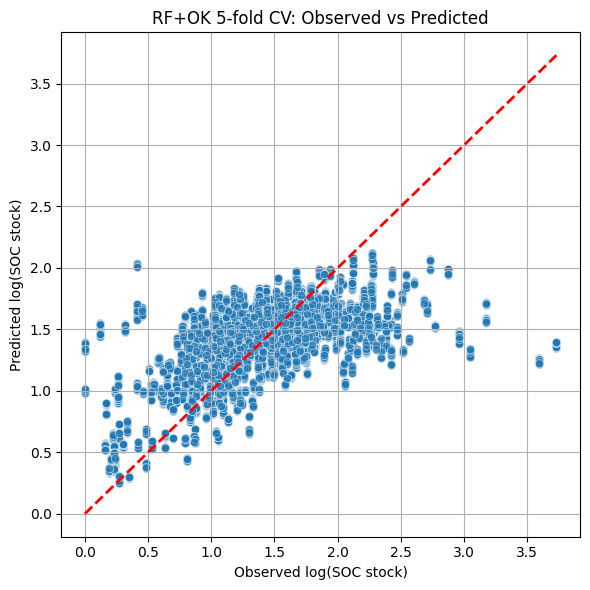

In [5]:
## best model based on r2, rmse, and mae

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths to your CSVs
# -----------------------------
summary_csv = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_summary_metrics_all_declusters.csv"
points_csv = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"

# -----------------------------
# 1) Summary table
# -----------------------------
summary_df = pd.read_csv(summary_csv)

# Compute mean metrics per model
metrics_table = summary_df.groupby("model")[["R2","RMSE","MAE"]].mean().sort_values("R2", ascending=False)
metrics_table["Best_Model"] = metrics_table["R2"] == metrics_table["R2"].max()
print("\n=== Mean CV metrics per model ===")
print(metrics_table)

# -----------------------------
# 2) Scatter plot observed vs predicted
# -----------------------------
points_df = pd.read_csv(points_csv)
rfok_df = points_df[points_df["model"]=="RF+OK_5fold"]

plt.figure(figsize=(6,6))
sns.scatterplot(x="y_true", y="y_pred", data=rfok_df, alpha=0.6)
plt.plot([rfok_df.y_true.min(), rfok_df.y_true.max()],
         [rfok_df.y_true.min(), rfok_df.y_true.max()],
         'r--', lw=2)
plt.xlabel("Observed log(SOC stock)")
plt.ylabel("Predicted log(SOC stock)")
plt.title("RF+OK 5-fold CV: Observed vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


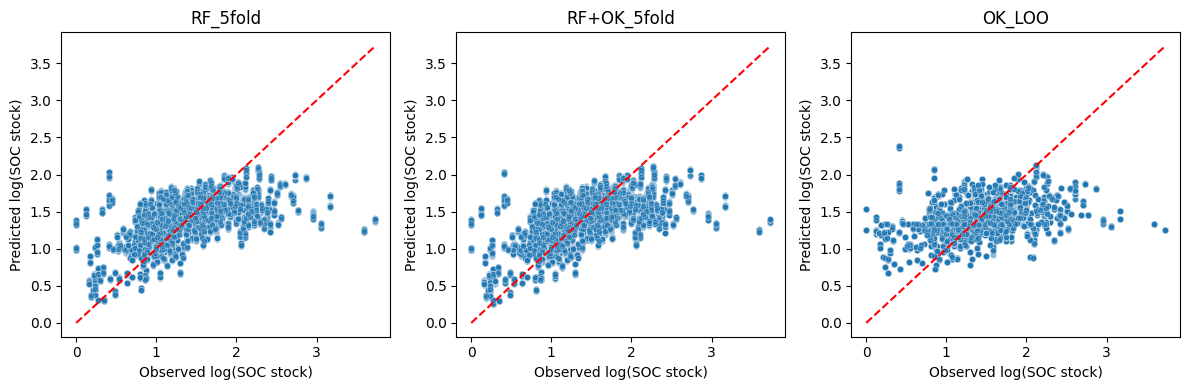

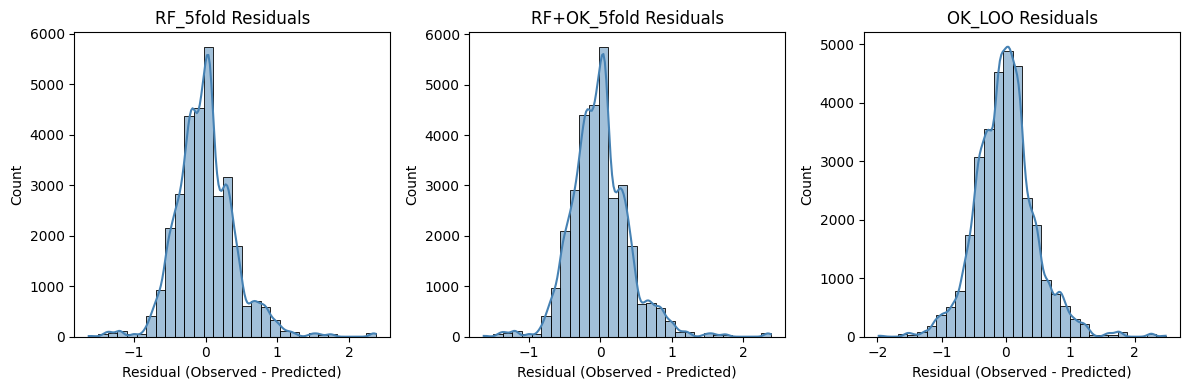

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load predictions
points_csv = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"
df = pd.read_csv(points_csv)

# Select models to compare
models = ["RF_5fold", "RF+OK_5fold", "OK_LOO"]

# Scatter plot: Predicted vs Observed
plt.figure(figsize=(12,4))
for i, model in enumerate(models, start=1):
    plt.subplot(1,3,i)
    df_model = df[df["model"]==model]
    sns.scatterplot(x="y_true", y="y_pred", data=df_model, alpha=0.5, s=20)
    plt.plot([df_model["y_true"].min(), df_model["y_true"].max()],
             [df_model["y_true"].min(), df_model["y_true"].max()],
             color="red", linestyle="--", label="1:1 line")
    plt.xlabel("Observed log(SOC stock)")
    plt.ylabel("Predicted log(SOC stock)")
    plt.title(model)
plt.tight_layout()
plt.show()

# Residuals plot
plt.figure(figsize=(12,4))
for i, model in enumerate(models, start=1):
    plt.subplot(1,3,i)
    df_model = df[df["model"]==model]
    sns.histplot(df_model["error"], bins=30, kde=True, color="steelblue")
    plt.xlabel("Residual (Observed - Predicted)")
    plt.ylabel("Count")
    plt.title(f"{model} Residuals")
plt.tight_layout()
plt.show()


In [26]:
import json
import os

# Path to the JSON file (update subset number if needed)
subset_index = 1  # Example: subset 1
json_path = f"/Users/inesschwartz/Desktop/model/results_cv_global/variogram_report_subset{subset_index}.json"

# Load the JSON
with open(json_path, "r") as f:
    variogram_report = json.load(f)

# Pretty-print the variogram report
import pprint
pprint.pprint(variogram_report)


[{'best_variogram': 'inferred',
  'fold': 1,
  'params': {'anisotropy_angle': 135.0,
             'anisotropy_scaling': 0.8229010885835532,
             'nugget': 0.07478736608256477,
             'range': 677865.4098010871,
             'sill': 0.08404669084437391}},
 {'best_variogram': 'inferred',
  'fold': 2,
  'params': {'anisotropy_angle': 0.0,
             'anisotropy_scaling': 1.0,
             'nugget': 0.07471492300760513,
             'range': 37974.74046506359,
             'sill': 0.07704634926629622}},
 {'best_variogram': 'fallback_mean', 'fold': 3, 'params': None},
 {'best_variogram': 'inferred',
  'fold': 4,
  'params': {'anisotropy_angle': 135.0,
             'anisotropy_scaling': 0.8321651823203976,
             'nugget': 0.0749596197122579,
             'range': 649702.1346267987,
             'sill': 0.07653028822207265}},
 {'best_variogram': 'inferred',
  'fold': 5,
  'params': {'anisotropy_angle': 135.0,
             'anisotropy_scaling': 0.8347406793505704,
      

## Back-transformation Script

In [3]:
# =========================================================
# Back-transformation Script
# Takes log-scale GeoTIFFs and converts to original units (Mg C/ha)
# =========================================================

import os
import numpy as np
import rasterio

# -----------------------------
# PATHS & SETTINGS
# -----------------------------
# INPUT_DIR = "/Users/inesschwartz/Desktop/model/bagged_maps"
INPUT_DIR = '/Users/inesschwartz/Desktop/model/bagged_maps_RFOK'
OUTPUT_DIR = '/Users/inesschwartz/Desktop/model/bagged_maps_RFOK' # or specify a different output directory

# Input files (log-scale)
INPUT_FILES = {
    # "RF_logSOC_mean.tif": "RF_SOC_mean_MgCha.tif",
    # "RF_logSOC_std.tif": "RF_SOC_std_MgCha.tif",
    # "OK_logSOC_mean.tif": "OK_SOC_mean_MgCha.tif",
    # "OK_logSOC_std.tif": "OK_SOC_std_MgCha.tif",
    # "RFOK_logSOC_mean.tif": "RFOK_SOC_mean_MgCha.tif",
    # "RFOK_logSOC_std.tif": "RFOK_SOC_std_MgCha.tif",

    # Correct naming for RFOK residual-kriging SOC predictions
    "RFOK_logSOC_mean.tif": "RFOKres_SOC_mean_MgCha1.tif",
    "RFOK_logSOC_std.tif.tif": "RFOKres_SOC_std_MgCha1.tif",
}


# -----------------------------
# Back-transform function
# -----------------------------
def backtransform_tif(input_path, output_path):
    """
    Read a log-scale GeoTIFF, back-transform to original units,
    and save as a new GeoTIFF with the same spatial properties.
    """
    with rasterio.open(input_path) as src:
        # Read the log-scale data
        log_data = src.read(1)
        
        # Back-transform: exp(log_value) = original value
        original_data = np.exp(log_data)
        
        # Copy metadata
        meta = src.meta.copy()
        
        # Write the back-transformed data
        with rasterio.open(output_path, "w", **meta) as dst:
            dst.write(original_data.astype("float32"), 1)
    
    return original_data


# -----------------------------
# Main processing
# -----------------------------
print("="*60)
print("BACK-TRANSFORMING LOG-SCALE GeoTIFFs TO ORIGINAL UNITS")
print("="*60)

summary_stats = {}

for input_file, output_file in INPUT_FILES.items():
    input_path = os.path.join(INPUT_DIR, input_file)
    output_path = os.path.join(OUTPUT_DIR, output_file)
    
    # Check if input file exists
    if not os.path.exists(input_path):
        print(f"⚠️  Skipping {input_file} (file not found)")
        continue
    
    print(f"\n📊 Processing: {input_file}")
    print(f"   → {output_file}")
    
    # Back-transform
    original_data = backtransform_tif(input_path, output_path)
    
    # Calculate statistics (excluding NaN/inf values)
    valid_data = original_data[np.isfinite(original_data)]
    
    if len(valid_data) > 0:
        summary_stats[output_file] = {
            "mean": valid_data.mean(),
            "std": valid_data.std(),
            "min": valid_data.min(),
            "max": valid_data.max(),
        }
        
        print(f"   ✓ Mean: {valid_data.mean():.2f} Mg C/ha")
        print(f"   ✓ Std:  {valid_data.std():.2f} Mg C/ha")
        print(f"   ✓ Range: [{valid_data.min():.2f}, {valid_data.max():.2f}] Mg C/ha")
    else:
        print("   ⚠️  No valid data found")

# -----------------------------
# Summary
# -----------------------------
print("\n" + "="*60)
print("SUMMARY OF BACK-TRANSFORMED MAPS")
print("="*60)

for file_name, stats in summary_stats.items():
    print(f"\n{file_name}:")
    print(f"  Mean: {stats['mean']:.2f} Mg C/ha")
    print(f"  Std:  {stats['std']:.2f} Mg C/ha")
    print(f"  Min:  {stats['min']:.2f} Mg C/ha")
    print(f"  Max:  {stats['max']:.2f} Mg C/ha")

print("\n" + "="*60)
print(f"✅ All back-transformed files saved to:")
print(f"   {OUTPUT_DIR}")
print("="*60)

BACK-TRANSFORMING LOG-SCALE GeoTIFFs TO ORIGINAL UNITS

📊 Processing: RFOK_logSOC_mean.tif
   → RFOKres_SOC_mean_MgCha1.tif
   ✓ Mean: 2.32 Mg C/ha
   ✓ Std:  2.07 Mg C/ha
   ✓ Range: [0.00, 9.27] Mg C/ha
⚠️  Skipping RFOK_logSOC_std.tif.tif (file not found)

SUMMARY OF BACK-TRANSFORMED MAPS

RFOKres_SOC_mean_MgCha1.tif:
  Mean: 2.32 Mg C/ha
  Std:  2.07 Mg C/ha
  Min:  0.00 Mg C/ha
  Max:  9.27 Mg C/ha

✅ All back-transformed files saved to:
   /Users/inesschwartz/Desktop/model/bagged_maps_RFOK


In [10]:
# =========================================================
# Back-Transformation Script Using CV Residuals
# Corrects log-scale SOC GeoTIFFs to Mg C/ha
# =========================================================

import os
import numpy as np
import pandas as pd
import rasterio

# -----------------------------
# USER SETTINGS
# -----------------------------

# CSV with CV predictions (residuals)
CV_PRED_CSV = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"

# Training dataset (optional, if needed for predictors)
TRAIN_CSV = "/Users/inesschwartz/Desktop/model/model_datasets/train_final1.csv"

# Input/output directories
INPUT_DIR = '/Users/inesschwartz/Desktop/model/bagged_maps'
OUTPUT_DIR = '/Users/inesschwartz/Desktop/model/bagged_maps_corrected'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Map of input log-scale GeoTIFFs to output filenames
INPUT_FILES = {
    "RFOK_logSOC_mean1.tif": "RFOK_SOC_mean_MgHa_corrected.tif",
    "RFOK_logSOC_std1.tif": "RFOK_SOC_std_MgHa_corrected.tif",
    "OK_logSOC_mean.tif": "OK_SOC_mean_MgHa_corrected.tif",
    "OK_logSOC_std.tif": "OK_SOC_std_corrected.tif",
    "RF_logSOC_mean1.tif": "RF_SOC_mean_MgHa_corrected.tif",
    "RF_logSOC_mean.tif": "RF_SOC_std_corrected.tif",
    "RFOKres_logSOC_mean.tif": "RFOKres_mean_MgHa_corrected.tif",
    "RFOKres_logSOC_std.tif": "RFOKres_SOC_std_corrected.tif"
}

# Column in CV CSV with log-scale SOC errors (residuals)
RESIDUAL_COL = "error"

# -----------------------------
# Step 1: Compute residual variance from CV predictions
# -----------------------------
print("="*60)
print("1️⃣ Computing residual variance from CV predictions")
print("="*60)

cv_df = pd.read_csv(CV_PRED_CSV)

# Optionally, filter by model if multiple models exist
cv_model = "RF_5fold"
cv_df = cv_df[cv_df["model"] == cv_model]

# Residuals are in log-space (y_true and y_pred are log(SOC))
residuals = cv_df[RESIDUAL_COL].values

# Compute variance
sigma2_logSOC = np.var(residuals)
print(f"✅ Residual variance of log(SOC) from CV: {sigma2_logSOC:.4f}")

# -----------------------------
# Step 2: Back-transform GeoTIFFs with log-normal bias correction
# -----------------------------
def backtransform_log_normal(input_path, output_path, sigma2):
    """
    Back-transform log-scale SOC raster with log-normal bias correction.
    """
    with rasterio.open(input_path) as src:
        log_data = src.read(1)
        # Apply log-normal bias correction
        corrected_data = np.exp(log_data + sigma2 / 2)

        # Copy metadata
        meta = src.meta.copy()
        meta.update(dtype=rasterio.float32)

        # Write corrected raster
        with rasterio.open(output_path, "w", **meta) as dst:
            dst.write(corrected_data.astype(np.float32), 1)

    return corrected_data

print("\n" + "="*60)
print("2️⃣ Back-transforming log-scale GeoTIFFs with bias correction")
print("="*60)

summary_stats = {}

for input_file, output_file in INPUT_FILES.items():
    input_path = os.path.join(INPUT_DIR, input_file)
    output_path = os.path.join(OUTPUT_DIR, output_file)

    if not os.path.exists(input_path):
        print(f"⚠️ Skipping {input_file} (file not found)")
        continue

    print(f"\n📊 Processing: {input_file}")
    print(f"   → {output_file}")

    corrected_data = backtransform_log_normal(input_path, output_path, sigma2_logSOC)

    # Compute statistics
    valid_data = corrected_data[np.isfinite(corrected_data)]
    if len(valid_data) > 0:
        summary_stats[output_file] = {
            "mean": valid_data.mean(),
            "std": valid_data.std(),
            "min": valid_data.min(),
            "max": valid_data.max(),
        }
        print(f"   ✓ Mean: {valid_data.mean():.2f} Mg C/ha")
        print(f"   ✓ Std:  {valid_data.std():.2f} Mg C/ha")
        print(f"   ✓ Range: [{valid_data.min():.2f}, {valid_data.max():.2f}] Mg C/ha")
    else:
        print("   ⚠️ No valid data found")

# -----------------------------
# Step 3: Summary
# -----------------------------
print("\n" + "="*60)
print("SUMMARY OF CORRECTED SOC MAPS")
print("="*60)
for file_name, stats in summary_stats.items():
    print(f"\n{file_name}:")
    print(f"  Mean: {stats['mean']:.2f} Mg C/ha")
    print(f"  Std:  {stats['std']:.2f} Mg C/ha")
    print(f"  Min:  {stats['min']:.2f} Mg C/ha")
    print(f"  Max:  {stats['max']:.2f} Mg C/ha")

print("\n" + "="*60)
print(f"✅ All corrected back-transformed files saved to:\n   {OUTPUT_DIR}")
print("="*60)


1️⃣ Computing residual variance from CV predictions
✅ Residual variance of log(SOC) from CV: 0.1672

2️⃣ Back-transforming log-scale GeoTIFFs with bias correction

📊 Processing: RFOK_logSOC_mean1.tif
   → RFOK_SOC_mean_MgHa_corrected.tif
   ✓ Mean: 4.13 Mg C/ha
   ✓ Std:  1.40 Mg C/ha
   ✓ Range: [1.29, 20.14] Mg C/ha

📊 Processing: RFOK_logSOC_std1.tif
   → RFOK_SOC_std_MgHa_corrected.tif
   ✓ Mean: 1.11 Mg C/ha
   ✓ Std:  0.02 Mg C/ha
   ✓ Range: [1.09, 1.63] Mg C/ha

📊 Processing: OK_logSOC_mean.tif
   → OK_SOC_mean_MgHa_corrected.tif
   ✓ Mean: 4.20 Mg C/ha
   ✓ Std:  0.75 Mg C/ha
   ✓ Range: [1.70, 16.38] Mg C/ha

📊 Processing: OK_logSOC_std.tif
   → OK_SOC_std_corrected.tif
   ✓ Mean: 1.09 Mg C/ha
   ✓ Std:  0.02 Mg C/ha
   ✓ Range: [1.09, 1.46] Mg C/ha

📊 Processing: RF_logSOC_mean1.tif
   → RF_SOC_mean_MgHa_corrected.tif
   ✓ Mean: 4.11 Mg C/ha
   ✓ Std:  1.26 Mg C/ha
   ✓ Range: [1.42, 9.75] Mg C/ha

📊 Processing: RF_logSOC_mean.tif
   → RF_SOC_std_corrected.tif
   ✓ Mean: 4.1

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_1409/2382449492.py:71: RuntimeWarning: overflow encountered in exp
  corrected_data = np.exp(log_data + sigma2 / 2)
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


## total SOC stock calculations

In [11]:
import rasterio
import numpy as np

# --------------------------------------------
# User input
# --------------------------------------------
soc_raster = "/Users/inesschwartz/Desktop/model/bagged_maps_corrected/RF_SOC_mean_MgHa_corrected.tif"

# --------------------------------------------
# Load raster
# --------------------------------------------
with rasterio.open(soc_raster) as src:
    soc = src.read(1).astype(float)  # Read band 1
    nodata = src.nodata

# --------------------------------------------
# Mask no-data values
# --------------------------------------------
if nodata is not None:
    soc = np.where(soc == nodata, np.nan, soc)

# --------------------------------------------
# Convert SOC from (Mg C / ha) to (Mg C / pixel)
# Each pixel = 1 km × 1 km = 100 hectares
# --------------------------------------------
pixel_area_ha = 100  # 1 km² = 100 ha
soc_MgC_per_pixel = soc * pixel_area_ha

# --------------------------------------------
# Compute total SOC stock (sum of all pixels)
# --------------------------------------------
total_SOC_MgC = np.nansum(soc_MgC_per_pixel)

# --------------------------------------------
# Optionally convert to Teragrams (Tg = million Mg)
# --------------------------------------------
total_SOC_TgC = total_SOC_MgC / 1_000_000

print("======================================")
print(" TOTAL SOIL ORGANIC CARBON STOCK")
print("======================================")
print(f"Total SOC in Angola (Mg C): {total_SOC_MgC:,.2f}")
print(f"Total SOC in Angola (Tg C): {total_SOC_TgC:,.4f} Tg")
print("======================================")


 TOTAL SOIL ORGANIC CARBON STOCK
Total SOC in Angola (Mg C): 518,183,748.46
Total SOC in Angola (Tg C): 518.1837 Tg


In [14]:
import rasterio
import numpy as np

# --------------------------------------------
# User input
# --------------------------------------------
soc_raster = "/Users/inesschwartz/Desktop/model/bagged_maps_corrected/RF_SOC_mean_MgHa_corrected.tif"


# --------------------------------------------
# Load raster
# --------------------------------------------
with rasterio.open(soc_raster) as src:
    soc = src.read(1).astype(float)
    nodata = src.nodata
    transform = src.transform

# --------------------------------------------
# Mask nodata
# --------------------------------------------
if nodata is not None:
    soc = np.where(soc == nodata, np.nan, soc)

# --------------------------------------------
# Pixel area in hectares (from geotransform!)
# --------------------------------------------
# Pixel size in meters:
pixel_width = abs(transform.a)
pixel_height = abs(transform.e)

pixel_area_m2 = pixel_width * pixel_height
pixel_area_ha = pixel_area_m2 / 10_000   # 10,000 m² = 1 ha

# --------------------------------------------
# Compute pixel SOC stock: (Mg/ha * ha/pixel)
# --------------------------------------------
soc_MgC_per_pixel = soc * pixel_area_ha

# --------------------------------------------
# Total SOC stock
# --------------------------------------------
total_SOC_MgC = np.nansum(soc_MgC_per_pixel)
total_SOC_TgC = total_SOC_MgC / 1_000_000  # Tg = million Mg

# --------------------------------------------
# Basic statistics matching Earth Engine output
# --------------------------------------------
soc_min = np.nanmin(soc)
soc_max = np.nanmax(soc)
soc_mean = np.nanmean(soc)
soc_std = np.nanstd(soc)

# --------------------------------------------
# Print results
# --------------------------------------------
print("======================================")
print(" LEGACY SOC STOCK — STATISTICS (Mg/ha)")
print("======================================")
print(f"Min SOC: {soc_min:,.2f} Mg/ha")
print(f"Max SOC: {soc_max:,.2f} Mg/ha")
print(f"Mean SOC: {soc_mean:,.2f} Mg/ha")
print(f"StdDev SOC: {soc_std:,.2f}")
print("--------------------------------------")
print(" TOTAL SOIL ORGANIC CARBON STOCK")
print("======================================")
print(f"Total SOC: {total_SOC_MgC:,.2f} Mg")
print(f"Total SOC: {total_SOC_TgC:,.4f} Tg")
print("======================================")


 LEGACY SOC STOCK — STATISTICS (Mg/ha)
Min SOC: 1.42 Mg/ha
Max SOC: 9.75 Mg/ha
Mean SOC: 4.11 Mg/ha
StdDev SOC: 1.26
--------------------------------------
 TOTAL SOIL ORGANIC CARBON STOCK
Total SOC: 518,183,748.46 Mg
Total SOC: 518.1837 Tg


In [1]:
import rasterio
import numpy as np

# --------------------------------------------
# User input
# --------------------------------------------
soc_raster = "/Users/inesschwartz/Desktop/model/bagged_maps/RF_SOC_mean_MgCha.tif"

# --------------------------------------------
# Load raster
# --------------------------------------------
with rasterio.open(soc_raster) as src:
    soc = src.read(1).astype(float)
    nodata = src.nodata
    transform = src.transform

# --------------------------------------------
# Mask nodata
# --------------------------------------------
if nodata is not None:
    soc = np.where(soc == nodata, np.nan, soc)

# --------------------------------------------
# Pixel area in hectares (from geotransform!)
# --------------------------------------------
# Pixel size in meters:
pixel_width = abs(transform.a)
pixel_height = abs(transform.e)

pixel_area_m2 = pixel_width * pixel_height
pixel_area_ha = pixel_area_m2 / 10_000   # 10,000 m² = 1 ha

# --------------------------------------------
# Compute pixel SOC stock: (Mg/ha * ha/pixel)
# --------------------------------------------
soc_MgC_per_pixel = soc * pixel_area_ha

# --------------------------------------------
# Total SOC stock
# --------------------------------------------
total_SOC_MgC = np.nansum(soc_MgC_per_pixel)
total_SOC_TgC = total_SOC_MgC / 1_000_000  # Tg = million Mg

# --------------------------------------------
# Basic statistics matching Earth Engine output
# --------------------------------------------
soc_min = np.nanmin(soc)
soc_max = np.nanmax(soc)
soc_mean = np.nanmean(soc)
soc_std = np.nanstd(soc)

# --------------------------------------------
# Print results
# --------------------------------------------
print("======================================")
print(" LEGACY SOC STOCK — STATISTICS (Mg/ha)")
print("======================================")
print(f"Min SOC: {soc_min:,.2f} Mg/ha")
print(f"Max SOC: {soc_max:,.2f} Mg/ha")
print(f"Mean SOC: {soc_mean:,.2f} Mg/ha")
print(f"StdDev SOC: {soc_std:,.2f}")
print("--------------------------------------")
print(" TOTAL SOIL ORGANIC CARBON STOCK")
print("======================================")
print(f"Total SOC: {total_SOC_MgC:,.2f} Mg")
print(f"Total SOC: {total_SOC_TgC:,.4f} Tg")
print("======================================")


 LEGACY SOC STOCK — STATISTICS (Mg/ha)
Min SOC: 1.31 Mg/ha
Max SOC: 8.96 Mg/ha
Mean SOC: 3.78 Mg/ha
StdDev SOC: 1.16
--------------------------------------
 TOTAL SOIL ORGANIC CARBON STOCK
Total SOC: 476,625,890.02 Mg
Total SOC: 476.6259 Tg


In [2]:
import rasterio
import numpy as np
import math

soc_raster = "/Users/inesschwartz/Desktop/model/bagged_maps/RF_SOC_mean_MgCha.tif"

with rasterio.open(soc_raster) as src:
    soc = src.read(1).astype(float)
    nodata = src.nodata
    crs = src.crs
    transform = src.transform
    width = src.width
    height = src.height
    bounds = src.bounds
    dtype = src.dtypes[0]

# mask
if nodata is not None:
    mask = (soc != nodata) & (~np.isnan(soc))
else:
    mask = ~np.isnan(soc)

valid = soc[mask]
n_pixels = mask.sum()
pix_w = abs(transform.a)
pix_h = abs(transform.e)
pixel_area_m2 = pix_w * pix_h
pixel_area_ha = pixel_area_m2 / 10000.0

print("RASTER PATH:", soc_raster)
print("CRS:", crs)
print("dtype:", dtype)
print("shape (h,w):", (height, width))
print("bounds:", bounds)
print("pixel size (m):", pix_w, "x", pix_h, "(m) -- pixel area (ha):", pixel_area_ha)
print("Valid pixels:", n_pixels)

print("\nBASIC STATISTICS (raw values)")
print("min:", np.nanmin(valid))
print("max:", np.nanmax(valid))
print("mean:", np.nanmean(valid))
print("std:", np.nanstd(valid))
print("median:", np.nanmedian(valid))

# quick histograms (bins)
hist, edges = np.histogram(valid, bins=20)
print("\nHistogram bins:", edges)
print("Counts:", hist)

# quick unit-sanity checks:
print("\nUNIT-CHECK HINTS:")
# 1) if values 0-1 maybe fraction -> percent?
if np.nanmax(valid) <= 1.0:
    print(" - Values ≤1.0: might be fraction (gC gSoil?), check if need *100 or *10000 conversion.")
# 2) if values 0-100 maybe t/ha (Mg/ha) plausible for 0-30 cm
if np.nanmax(valid) > 20 and np.nanmax(valid) < 1000:
    print(" - Values in ~0-1000 range: could be Mg/ha (t/ha) but your mean ~", np.nanmean(valid))
# 3) if values small (0-10) and filename suggests MgCha: maybe it's Mg C (per hectare) but very low
if np.nanmax(valid) < 10:
    print(" - Max <10: suspiciously small for Mg/ha to 0-30cm. Could be per m² or percent; check how RF outputs units.")


RASTER PATH: /Users/inesschwartz/Desktop/model/bagged_maps/RF_SOC_mean_MgCha.tif
CRS: EPSG:32733
dtype: float32
shape (h,w): (1521, 1352)
bounds: BoundingBox(left=143882.578, bottom=7995805.0427, right=1495882.578, top=9516805.0427)
pixel size (m): 1000.0 x 1000.0 (m) -- pixel area (ha): 100.0
Valid pixels: 1259342

BASIC STATISTICS (raw values)
min: 1.3081811666488647
max: 8.9640531539917
mean: 3.784721624605092
std: 1.159778671205085
median: 3.681274890899658

Histogram bins: [1.30818117 1.69097477 2.07376837 2.45656196 2.83935556 3.22214916
 3.60494276 3.98773636 4.37052996 4.75332356 5.13611716 5.51891076
 5.90170436 6.28449796 6.66729156 7.05008516 7.43287876 7.81567236
 8.19846596 8.58125955 8.96405315]
Counts: [ 38380  21804  67698 174285 183291 122103 110280 110426 144329 117335
  84222  49338  18349   8500   4121   1783   1406    877    576    239]

UNIT-CHECK HINTS:
 - Max <10: suspiciously small for Mg/ha to 0-30cm. Could be per m² or percent; check how RF outputs units.


In [ ]:
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import geopandas as gpd
import os

soc_raster = "/Users/inesschwartz/Desktop/model/bagged_maps/RF_SOC_mean_MgCha.tif"
# optional: path to Angola polygon (GeoJSON / Shapefile). If you don't have it, set to None.
angola_shp = "/path/to/angola_shapefile.shp"  # <-- replace or set to None

# 1) load raster
with rasterio.open(soc_raster) as src:
    soc = src.read(1).astype(float)
    nodata = src.nodata
    src_crs = src.crs
    src_transform = src.transform
    src_profile = src.profile

# 2) mask nodata
if nodata is not None:
    soc = np.where(soc == nodata, np.nan, soc)

# 3) optional clipping to Angola shapefile (recommended)
if angola_shp and os.path.exists(angola_shp):
    ang = gpd.read_file(angola_shp)
    ang = ang.to_crs(src_crs)    # reproject polygon to raster CRS
    geom = [ang.unary_union.__geo_interface__]
    with rasterio.open(soc_raster) as src:
        out_image, out_transform = mask(src, geom, crop=True, nodata=np.nan)
        soc = out_image[0].astype(float)
        src_transform = out_transform
        src_profile = src.profile
    print("Clipped raster to Angola extent. New shape:", soc.shape)

# 4) compute pixel area based on transform (works both for projected CRS or geographic; if geographic degrees, you should convert to equal-area)
pixel_width = abs(src_transform.a)
pixel_height = abs(src_transform.e)
# If CRS is geographic (EPSG:4326), pixel sizes are degrees -> compute approximate area per pixel (use lat mid)
if src_crs and src_crs.to_string().startswith('EPSG:4326'):
    # approximate: compute meters per degree at mean latitude of raster
    import math
    # get center lat
    rows, cols = soc.shape
    x0 = src_transform.c
    y0 = src_transform.f
    center_lon = x0 + (cols/2.0)*src_transform.a
    center_lat = y0 + (rows/2.0)*src_transform.e
    meters_per_deg_lat = 111132.954 - 559.822 * math.cos(2*math.radians(center_lat)) + 1.175 * math.cos(4*math.radians(center_lat))
    meters_per_deg_lon = (111412.84 * math.cos(math.radians(center_lat)) - 93.5 * math.cos(3*math.radians(center_lat)))
    pixel_area_m2 = (pixel_width * meters_per_deg_lon) * (abs(pixel_height) * meters_per_deg_lat)
else:
    pixel_area_m2 = pixel_width * pixel_height

pixel_area_ha = pixel_area_m2 / 10000.0

# 5) compute totals like GEE: soc (Mg/ha) * pixel_area_ha -> Mg/pixel, sum ignoring nan
soc_Mg_per_pixel = soc * pixel_area_ha
total_Mg = np.nansum(soc_Mg_per_pixel)
total_Tg = total_Mg / 1e6

print("Pixel area (ha):", pixel_area_ha)
print("Valid pixels:", np.isfinite(soc_Mg_per_pixel).sum())
print("Min (Mg/ha):", np.nanmin(soc))
print("Max (Mg/ha):", np.nanmax(soc))
print("Mean (Mg/ha):", np.nanmean(soc))
print("Std (Mg/ha):", np.nanstd(soc))
print("TOTAL SOC (Mg):", f"{total_Mg:,.2f}")
print("TOTAL SOC (Tg):", f"{total_Tg:,.4f}")
